In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
sys.path.append('../')
sys.path.append('../util/')
import feedforward_robust as ffr
import ipdb
from mnist_corruption import *
from util import *

#Read the counter
ctr_file = "counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

W0920 10:33:47.244839 4522669504 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Setup - Dataset stuff
dataset, input_shape, num_classes = get_dataset()
x_train_flat, y_train = dataset[0] 
x_test_flat, y_test = dataset[1] 
hidden_sizes = [32,32,32,32,32,32,32]

In [4]:
x_train_flat.shape

(60000, 784)

In [5]:
def plot_singular_values(matrix, idx, title):
    _, sig, V = np.linalg.svd(matrix)
    plt.plot(range(len(sig)), sig, label = "Layer number %d" %idx)
    plt.legend(loc = 'upper right')
    plt.title(title)
    return sig

In [6]:
def regular_training(config_inp):
    eps_train = config_inp['eps_train'] 
    eps_test = config_inp['eps_test'] 
    tensorboard_dir = config_inp['tensorboard_dir'] 
    weights_dir = config_inp['weights_dir']
    load_counter = config_inp['load_counter'] 
    sigma = config_inp['sigma']
    scope_name = config_inp['scope_name']
    
    with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE) as scope:
        sess = tf.Session()
        logdir = tensorboard_dir + str(counter) + "/non_robust"

        #Create, train and test model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma =sigma)
        logger.info("Created model successfully. Now going to load weights")
        
        #Restore weights
        weights, biases = model.get_weights()
        weights_exp = weights + biases
        saver = tf.train.Saver(weights_exp)
        weights_path = saver.restore(sess, weights_dir + "model_" + str(load_counter) + ".ckpt")

        writer.add_graph(sess.graph)

        loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
        logger.info("----Regular test accuracy and loss ----")
        logger.info((loss_reg, acc_reg))

        
        with tf.variable_scope("testing_benign") as scope:
            loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
            logger.info("----Regular test accuracy and loss ----")
            logger.info((loss_reg, acc_reg))


        with tf.variable_scope("testing_adversarial") as scope:
            loss_fgsm, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
            logger.info("----FGSM test accuracy and loss ----")
            logger.info((loss_fgsm, acc_fgsm))
            x_test_flat_adv = model.fgsm_np(sess, x_test_flat, y_test, eps_test)
    return model, sess

In [7]:
def hybrid_training(config_inp):
    eps_train = config_inp['eps_train'] 
    eps_test = config_inp['eps_test'] 
    tensorboard_dir = config_inp['tensorboard_dir'] 
    weights_dir = config_inp['weights_dir']
    load_counter_non_robust = config_inp['load_counter_non_robust'] 
    load_counter_robust = config_inp['load_counter_robust']
    sigma = config_inp['sigma']
    scope_name = config_inp['scope_name']
    should_slash = config_inp['should_slash']
    slash_factor = config_inp['slash_factor']
    
    with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE) as scope:
        sess = tf.Session()
        logdir = tensorboard_dir + str(counter)

        #Create, train and test model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma =sigma)
        feed_dict = {model.x: x_train_flat, model.y: y_train}
        sess.run(tf.global_variables_initializer(), feed_dict = feed_dict)
        logger.info("Created model successfully. Now going to load weights")
        
        #Restore all weights from non-robust
        weights, biases = model.get_weights()
        weights_exp = weights + biases
        saver = tf.train.Saver(weights_exp)
        weights_path = saver.restore(sess, weights_dir + "model_" + str(load_counter_non_robust) + ".ckpt")
        
        #Optionally slash weights
        if should_slash:
            model.slash_weights(sess, slash_factor)
            logger.info("Successfully slashed weights")
        
        logger.info("Successfully restored weights from non rob model.")

        #Restore the first and last layer from the robust model
        weights, biases = model.get_weights()
        selected_vars = [weights[0]] + [weights[-1]] + [biases[0]] + [biases[-1]]
        saver = tf.train.Saver(selected_vars)
        weights_path_rob = saver.restore(sess, weights_dir + "model_" + str(load_counter_robust) + ".ckpt")
        
        logger.info("Successfully restored weights from rob model.")
        
        #Run one epoch to try to make the weights more compatible with each other
        
        model.fit(sess, x_train_flat[0:10000], y_train[0:10000], training_epochs = 1, reg = 0, lr =3e-3)
        logger.info("Trained one epoch to attempt to make weights from different models compatible")
        
        #writer.add_graph(sess.graph)
        loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
        logger.info("----Regular test accuracy and loss ----")
        logger.info((loss_reg, acc_reg))

        logger.info("Evaluating on FGSM points now.")
        loss_fgsm, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
        logger.info("----FGSM test accuracy and loss ----")
        logger.info((loss_fgsm, acc_fgsm))
        x_test_flat_adv = model.fgsm_np(sess, x_test_flat, y_test, eps_test)
    
        logger.info("Evaluating on PGD points now.")
        loss_pgd, acc_pgd = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = True, eta=1e-2, num_iter = 40)
        logger.info("----PGD test accuracy and loss ----")
        logger.info((loss_pgd , acc_pgd))
        
    return model, sess

In [8]:
def adversarial_training(config):
    eps_train = config['eps_train'] 
    eps_test = config['eps_test'] 
    tensorboard_dir = config['tensorboard_dir'] 
    weights_dir = config['weights_dir']
    load_counter = config['load_counter'] 
    sigma = config['sigma']
    scope_name_rob = config['scope_name']
    sess = tf.Session()
    hidden_sizes = [32,32,32,32,32,32,32]
    
    dataset = ((x_train_flat, y_train), (x_test_flat, y_test))

    with tf.variable_scope(scope_name_rob, reuse = tf.AUTO_REUSE) as scope:
        tmp = set(tf.all_variables())
        logdir = tensorboard_dir + str(counter) + "/robust"
        writer_robust = tf.summary.FileWriter(logdir)
        logger.info("Adversarial Training")
        robust_model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer_robust, scope = scope_name_rob, logger = logger, sigma = sigma)
        
        sess.run(tf.initialize_variables(set(tf.all_variables()) - tmp))
        robust_model.adv_fit(sess, x_train_flat, y_train, eps_train, lr = 3e-4, training_epochs = 20)

        print(robust_model.evaluate(sess, x_test_flat, y_test))
        print(robust_model.adv_evaluate(sess, x_test_flat, y_test, eps_test))
    return robust_model, sess

In [9]:
def activation_distance(activation_list):
    diff = []
    diff_norms = []
    for i in range(len(activation_list) - 1):
        difference = activation_list[i+1] - activation_list[i]
        diff.append(difference)
        diff_norms.append(np.linalg.norm(difference)/np.linalg.norm(activation_list[i]))
    return diff, diff_norms

In [10]:
def make_plot_acc_vs_eps_black_box(model_list, sess_list, eps_list, angle_list, legend_list, scope_list):
    x_test_2d = np.array([vec.reshape((28,28)) for vec in x_test_flat])
    fig = plt.figure(figsize = (10,10))
    ax_gb = fig.add_subplot(2, 2, 1)
    ax_rp = fig.add_subplot(2, 2, 2)
    ax_bw = fig.add_subplot(2, 2, 3)
    ax_rot = fig.add_subplot(2, 2, 4)
    
    for idx, model in enumerate(model_list):
        sess = sess_list[idx]
        legend = legend_list[idx]
        gb_acc = []
        rp_acc = []
        bw_acc = []
        rot_acc = []
        
        scope_name = scope_list[idx]
        
        for (idx, eps_test) in enumerate(eps_list):
            x_test_gaussian_blurred = flatten_mnist(gaussian_blurring(x_test_2d, eps_test))[0]
            x_test_random_pert = flatten_mnist(random_perturbation(x_test_2d, eps_test))[0]
            x_test_black_white = flatten_mnist(random_blackout_whiteout(x_test_2d, eps_test))[0]
            angle = angle_list[idx]
            x_test_rot = flatten_mnist(rotate(x_test_2d, angle))[0]
            
            #ipdb.set_trace()
            gb_acc.append(model.evaluate(sess, x_test_gaussian_blurred, y_test)[1])
            rp_acc.append(model.evaluate(sess, x_test_random_pert, y_test)[1])
            bw_acc.append(model.evaluate(sess, x_test_black_white, y_test)[1])
            rot_acc.append(model.evaluate(sess, x_test_rot, y_test)[1])

        ax_gb.plot(eps_list, gb_acc, label = legend)
        ax_rp.plot(eps_list, rp_acc, label = legend)
        ax_bw.plot(eps_list, bw_acc, label = legend)
        ax_rot.plot(angle_list, rot_acc, label = legend)
 
    ax_gb.set_title("Gaussian blurring")
    ax_rp.set_title("Random perturbation")
    ax_bw.set_title("Blackwhite")
    ax_rot.set_title("Rotation")
    
    plt.legend(loc = (2.5, 0.7))
    plt.show()
    return True

In [11]:
def make_plot_acc_vs_eps(model_list, sess_list, eps_list, legend_list, scope_list, pgd = False):
    fig = plt.figure()
    x_test_2d = [vec.reshape((28,28)) for vec in x_test_flat]
    
    for idx, model in enumerate(model_list):
        sess = sess_list[idx]
        legend = legend_list[idx]
        y_array = []
        scope_name = scope_list[idx]
        
        for eps_test in eps_list:
            if not pgd:
                _, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
                y_array.append(acc_fgsm)
            else:
                with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE) as scope:
                    _, acc_pgd = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = True, eta=1e-2, num_iter = 50)
                    y_array.append(acc_pgd)
                    
        plt.plot(eps_list, y_array, label = legend)
    
    plt.legend(loc = 1)
    plt.show()
    return True

In [12]:
def get_stats_all_models(model_list, sess_list, scope_list):
    
    eps_test = 0.1
    reg_evals = []
    adv_evals = []
    margins = []
    dphi_dxs = []
        
    for idx, model in enumerate(model_list):
        sess = sess_list[idx]
        y_array = []
        scope_name = scope_list[idx]

        with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE) as scope:
            #Get dphi_dx
            dphi_dx_test = model.get_dphi_dx(sess, x_test_flat)[0]
            dphi_dxs.append(np.mean(np.abs(dphi_dx_test)))
            
            #Get reg_evals
            reg_evals.append(model.evaluate(sess, x_test_flat, y_test))
            
            #Get adv_evals
            adv_evals.append(model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False))
            
            #Get margins
            x_test_feat_pert = model.attack_featurization_space(sess, x_test_flat, y_test, 1.0, 0.1, 200)
            loss_feat_adv, acc_feat_adv = model.evaluate_from_featurizations(sess, x_test_feat_pert, y_test)
            margins.append(acc_feat_adv)
            
    return reg_evals, adv_evals, margins, dphi_dxs

In [13]:
def make_dist_plot_all_models(model_list, sess_list, scope_list, legend_list, order):
    plt.figure()
    
    for idx, model in enumerate(model_list):
        sess = sess_list[idx]
        scope_name = scope_list[idx]
        legend = legend_list[idx]

        with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE) as scope:
            y_array = model.get_distance(sess, 0.10, x_test_flat, y_test, order = order)[0]
            plt.plot(range(len(y_array)), y_array, label = legend)
    
    plt.legend()
    plt.show()
    return True

In [14]:
scope_list = ["hybrid", "model_non_robust", ]

In [15]:
x_test_2d = [vec.reshape((28,28)) for vec in x_test_flat]

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


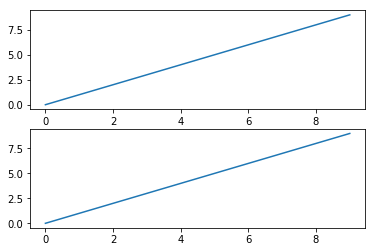

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)


ax1.plot(range(10), range(10))
ax2.plot(range(10), range(10))

fig.show()

### Trying out different corruptions 

In [17]:
#Random trying out stuff
x_test_gaussian_blurred = gaussian_blurring(x_test_2d, 0.5)

In [18]:
x_test_rotated = rotate(x_test_2d, angle = 45)

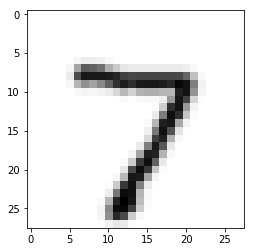

In [19]:
plt.imshow(x_test_gaussian_blurred[0], cmap = plt.cm.binary)

# Hybrid Training

In [20]:
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter_robust'] = 280
config['load_counter_non_robust'] = 282
config['should_slash'] = False
config['slash_factor'] = 0.70

config['sigma'] = tf.nn.relu

config['scope_name'] = "hybrid"

In [21]:
model_hybrid, sess_hybrid = hybrid_training(config)

Initialized instance variables of the robust model class
I0920 10:33:51.928591 4522669504 feedforward_robust.py:30] Initialized instance variables of the robust model class
W0920 10:33:51.930343 4522669504 deprecation_wrapper.py:119] From ../feedforward_robust.py:34: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0920 10:33:51.933995 4522669504 feedforward_robust.py:36] Created placeholders for x and y
W0920 10:33:51.935344 4522669504 deprecation_wrapper.py:119] From ../util.py:34: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0920 10:33:51.935941 4522669504 deprecation_wrapper.py:119] From ../util.py:34: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0920 10:33:51.936928 4522669504 deprecation_wrapper.py:119] From ../util.py:36: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0920 10:33:52.029

iteration: 0
loss 0.788455
iteration: 1
loss 0.964818
iteration: 2
loss 1.151288
iteration: 3
loss 1.345418
iteration: 4
loss 1.544904
iteration: 5
loss 1.744141
iteration: 6
loss 1.941493
iteration: 7
loss 2.133634
iteration: 8
loss 2.323750
iteration: 9
loss 2.502267
iteration: 10
loss 2.675588
iteration: 11
loss 2.837028
iteration: 12
loss 2.991722
iteration: 13
loss 3.132497
iteration: 14
loss 3.262680
iteration: 15
loss 3.377474
iteration: 16
loss 3.479832
iteration: 17
loss 3.569660
iteration: 18
loss 3.644774
iteration: 19
loss 3.705488
iteration: 20
loss 3.756016
iteration: 21
loss 3.803378
iteration: 22
loss 3.844472
iteration: 23
loss 3.883268
iteration: 24
loss 3.915355
iteration: 25
loss 3.946588
iteration: 26
loss 3.973013
iteration: 27
loss 3.998304
iteration: 28
loss 4.018568
iteration: 29
loss 4.039519
iteration: 30
loss 4.056814
iteration: 31
loss 4.073850
iteration: 32
loss 4.086747
iteration: 33
loss 4.101546
iteration: 34
loss 4.111086
iteration: 35
loss 4.123694
it

This is to confirm that attack does not violate constraints
I0920 10:33:58.262482 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:33:58.270594 4522669504 feedforward_robust.py:210] Should be no more than eps
0.10000005352730845
I0920 10:33:58.378144 4522669504 feedforward_robust.py:211] 0.10000005352730845
----PGD test accuracy and loss ----
I0920 10:33:58.403510 4522669504 <ipython-input-7-ee235a87947b>:63] ----PGD test accuracy and loss ----
(4.1568065, 0.2127)
I0920 10:33:58.406749 4522669504 <ipython-input-7-ee235a87947b>:64] (4.1568065, 0.2127)


In [22]:
dphi_dx_test_hybrid = model_hybrid.get_dphi_dx(sess_hybrid, x_test_flat)[0]

In [23]:
np.mean(np.abs(dphi_dx_test_hybrid))

0.39415258

In [24]:
dpred_dx_test_hybrid = model_hybrid.get_pred_dx(sess_hybrid, x_test_flat)[0]
np.mean(np.abs(dpred_dx_test_hybrid))

0.92792237

## Regular Training

In [25]:
#tf.reset_default_graph()

In [26]:
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter'] = 222
config['sigma'] = tf.nn.relu

config['scope_name'] = "model_non_robust"

In [27]:
config['scope_name']

'model_non_robust'

In [28]:
model_non_robust, sess_non_robust = regular_training(config)

Initialized instance variables of the robust model class
I0920 10:33:59.163604 4522669504 feedforward_robust.py:30] Initialized instance variables of the robust model class
Created placeholders for x and y
I0920 10:33:59.166881 4522669504 feedforward_robust.py:36] Created placeholders for x and y
Created layers and tensor for logits
I0920 10:33:59.302040 4522669504 feedforward_robust.py:40] Created layers and tensor for logits
Added loss computation to the graph
I0920 10:33:59.329854 4522669504 feedforward_robust.py:45] Added loss computation to the graph
Added accuracy computation to the graph
I0920 10:33:59.336389 4522669504 feedforward_robust.py:49] Added accuracy computation to the graph
Model graph was created
I0920 10:33:59.340824 4522669504 feedforward_robust.py:52] Model graph was created
Created model successfully. Now going to load weights
I0920 10:33:59.346379 4522669504 <ipython-input-6-cc1dd069280b>:17] Created model successfully. Now going to load weights
Model was evalua

In [29]:
with tf.variable_scope(config['scope_name']) as scope:
    weights_non_robust = model_non_robust.get_weights_np(sess_non_robust)

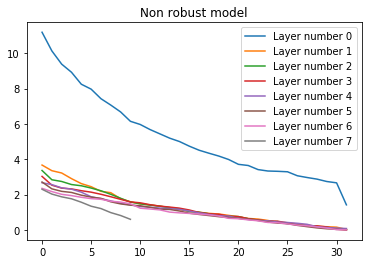

In [30]:
#Original without regularization
sing_vals = []
for (idx, weight_matrix) in enumerate(weights_non_robust):
        sig = plot_singular_values(weight_matrix, idx, "Non robust model")
        sing_vals.append(sig)

In [31]:
#Regular points
acts = model_non_robust.get_activation(sess_non_robust, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = model_non_robust.fgsm_np(sess_non_robust, x_test_flat, y_test, config['eps_test'])
acts_adv = model_non_robust.get_activation(sess_non_robust, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [32]:
diff_norm

[1.2221951, 1.2958775, 1.2866542, 1.2522035, 1.2535323, 1.1977569]

In [33]:
diff_norm_adv

[1.1699435, 1.2277226, 1.1832038, 1.2514116, 1.2267895, 1.1607223]

In [34]:
dphi_dx_test = model_non_robust.get_dphi_dx(sess_non_robust, x_test_flat)[0]

In [35]:
dphi_dx_test[0]

array([ 2.57825583e-01,  8.78084004e-02, -7.54263550e-02,  1.16312869e-01,
       -1.05404118e-02,  5.11546850e-01,  1.08980112e-01,  3.60112667e-01,
       -1.30970672e-01,  2.86065906e-01, -2.51386076e-01, -5.32598734e-01,
       -9.00848925e-01, -8.47756684e-01, -4.31117505e-01, -1.08172905e+00,
        3.92692178e-01, -1.76614270e-01, -1.28510660e-02, -8.11763108e-02,
       -3.29416454e-01, -9.48862731e-02, -1.95206463e-01, -9.28842127e-02,
       -5.44355273e-01,  2.50157624e-01,  1.45502254e-01, -1.56610504e-01,
       -2.50830531e-01, -2.74944484e-01, -3.48501772e-01, -3.18996042e-01,
        2.88076341e-01, -3.94406408e-01, -1.00904870e+00, -9.62924361e-01,
       -3.92116129e-01, -6.67419016e-01, -1.37607694e+00, -5.23529112e-01,
       -1.57230663e+00, -1.94908154e+00, -4.86297607e-01, -5.91748834e-01,
       -5.78102291e-01, -1.01870322e+00, -1.40130401e+00, -1.06577003e+00,
       -1.01430583e+00, -1.43360734e+00, -1.34260607e+00, -1.00455070e+00,
        4.18147981e-01, -

In [36]:
dphi_dx_test_non_robust = dphi_dx_test
np.mean(np.abs(dphi_dx_test_non_robust))

0.8664375

In [37]:
dpred_dx_test_non_robust = model_non_robust.get_pred_dx(sess_non_robust, x_test_flat)[0]
np.mean(np.abs(dpred_dx_test_non_robust))

0.59841245

In [38]:
with tf.variable_scope(config['scope_name'], reuse = tf.AUTO_REUSE) as scope:
    x_test_feat_pert = model_non_robust.attack_featurization_space(sess_non_robust, x_test_flat, y_test, 1.0, 0.1, 200)
    loss_feat_adv, acc_feat_adv = model_non_robust.evaluate_from_featurizations(sess_non_robust, x_test_feat_pert, y_test)
    print(loss_feat_adv, acc_feat_adv)

Obtained featurizations
I0920 10:34:01.782996 4522669504 feedforward_robust.py:216] Obtained featurizations
W0920 10:34:01.790524 4522669504 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:2618: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Created feat adv graph
I0920 10:34:02.062412 4522669504 feedforward_robust.py:224] Created feat adv graph


iteration: 0
loss 0.253283
iteration: 1
loss 0.329387
iteration: 2
loss 0.420513
iteration: 3
loss 0.527368
iteration: 4
loss 0.649911
iteration: 5
loss 0.787681
iteration: 6
loss 0.939047
iteration: 7
loss 1.101000
iteration: 8
loss 1.270130
iteration: 9
loss 1.442689
iteration: 10
loss 1.614176
iteration: 11
loss 1.780380
iteration: 12
loss 1.937343
iteration: 13
loss 2.081459
iteration: 14
loss 2.209735
iteration: 15
loss 2.318654
iteration: 16
loss 2.406611
iteration: 17
loss 2.472138
iteration: 18
loss 2.514010
iteration: 19
loss 2.531872
iteration: 20
loss 2.537449
iteration: 21
loss 2.542706
iteration: 22
loss 2.547621
iteration: 23
loss 2.552153
iteration: 24
loss 2.556336
iteration: 25
loss 2.560221
iteration: 26
loss 2.563772
iteration: 27
loss 2.567037
iteration: 28
loss 2.570028
iteration: 29
loss 2.572738
iteration: 30
loss 2.575221
iteration: 31
loss 2.577500
iteration: 32
loss 2.579569
iteration: 33
loss 2.581450
iteration: 34
loss 2.583166
iteration: 35
loss 2.584698
it

Found adversarial featurizations
I0920 10:34:03.771163 4522669504 feedforward_robust.py:219] Found adversarial featurizations
Model was evaluated from featurizations
I0920 10:34:03.792239 4522669504 feedforward_robust.py:383] Model was evaluated from featurizations


loss 2.598425
iteration: 179
loss 2.598425
iteration: 180
loss 2.598425
iteration: 181
loss 2.598425
iteration: 182
loss 2.598425
iteration: 183
loss 2.598425
iteration: 184
loss 2.598425
iteration: 185
loss 2.598425
iteration: 186
loss 2.598425
iteration: 187
loss 2.598425
iteration: 188
loss 2.598425
iteration: 189
loss 2.598425
iteration: 190
loss 2.598425
iteration: 191
loss 2.598425
iteration: 192
loss 2.598425
iteration: 193
loss 2.598425
iteration: 194
loss 2.598425
iteration: 195
loss 2.598425
iteration: 196
loss 2.598425
iteration: 197
loss 2.598425
iteration: 198
loss 2.598425
iteration: 199
loss 2.598425
2.5984254 0.3251


In [39]:
adv_images_fgsm = model_non_robust.fgsm_np(sess_non_robust, x_test_flat, y_test, 0.10)

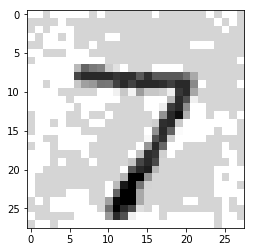

In [40]:
test_image = adv_images_fgsm[0]
two_d = test_image.reshape((28,28))
plt.imshow(two_d, cmap = plt.cm.binary)

In [41]:
"""
test_image = adv_images_pgd[0]
two_d = test_image.reshape((28,28))
plt.imshow(two_d, cmap = plt.cm.binary)
"""

'\ntest_image = adv_images_pgd[0]\ntwo_d = test_image.reshape((28,28))\nplt.imshow(two_d, cmap = plt.cm.binary)\n'

## Trace regularization for first layer

In [42]:
#Config
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter'] = 121
config['sigma'] = tf.nn.relu

config['scope_name'] = "model_non_robust"

In [43]:
config['scope_name']

'model_non_robust'

In [44]:
reg_model, sess_reg = regular_training(config)

Initialized instance variables of the robust model class
I0920 10:34:04.646522 4522669504 feedforward_robust.py:30] Initialized instance variables of the robust model class
Created placeholders for x and y
I0920 10:34:04.649713 4522669504 feedforward_robust.py:36] Created placeholders for x and y
Created layers and tensor for logits
I0920 10:34:04.693832 4522669504 feedforward_robust.py:40] Created layers and tensor for logits
Added loss computation to the graph
I0920 10:34:04.716521 4522669504 feedforward_robust.py:45] Added loss computation to the graph
Added accuracy computation to the graph
I0920 10:34:04.723319 4522669504 feedforward_robust.py:49] Added accuracy computation to the graph
Model graph was created
I0920 10:34:04.726408 4522669504 feedforward_robust.py:52] Model graph was created
Created model successfully. Now going to load weights
I0920 10:34:04.733400 4522669504 <ipython-input-6-cc1dd069280b>:17] Created model successfully. Now going to load weights
Model was evalua

In [45]:
with tf.variable_scope(config['scope_name']) as scope:
    weights = reg_model.get_weights_np(sess_reg)

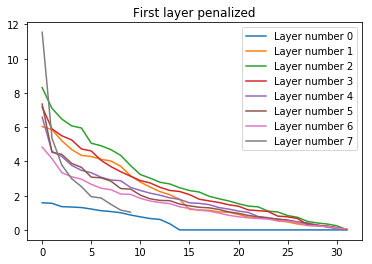

In [46]:
#With regularization
sing_vals_reg = []
for (idx, weight_matrix) in enumerate(weights):
        sig = plot_singular_values(weight_matrix, idx, "First layer penalized")
        sing_vals_reg.append(sig)

**Interpretation** This is pretty interesting. When you penalize the singular values of the first layer, all the other layers start increasing to compensate - I'm guessing to keep the expressiveness high. Probably, if we penalize all the singular values, it may not learn anything?

So we still have not suceeded at replicating the singular value spectrum of the robust model - so it is difficult to conclude whether the singular value spectrum is a determinant of adversarial robustness or not

In [47]:
#With regularization - first layer
sing_vals_reg

[array([1.5870155e+00, 1.5522803e+00, 1.3584403e+00, 1.3370733e+00,
        1.3070780e+00, 1.2188531e+00, 1.1234620e+00, 1.0728732e+00,
        1.0041257e+00, 8.7067133e-01, 7.6290888e-01, 6.6413921e-01,
        6.1234343e-01, 3.5728675e-01, 6.2625506e-04, 4.9098406e-04,
        4.8556362e-04, 4.5167084e-04, 3.1356234e-04, 3.0216103e-04,
        2.7841594e-04, 2.0602574e-04, 1.9646439e-04, 1.8619838e-04,
        1.4287693e-04, 1.3560396e-04, 1.2213681e-04, 3.9542541e-05,
        3.5572761e-05, 1.7289583e-05, 8.5304418e-06, 5.9684144e-06],
       dtype=float32),
 array([6.035554  , 5.8620715 , 5.20899   , 4.6957164 , 4.3550816 ,
        4.287016  , 4.125534  , 4.0239434 , 3.7177262 , 3.1656983 ,
        2.7954736 , 2.499863  , 2.23836   , 2.055546  , 1.7796141 ,
        1.2052387 , 1.1660684 , 1.1480169 , 1.0525272 , 1.0315014 ,
        0.90306103, 0.74932116, 0.6895752 , 0.6741662 , 0.5238548 ,
        0.469349  , 0.34676093, 0.27730793, 0.22861174, 0.21915486,
        0.12821923, 0.04

In [48]:
#Regular points
acts = reg_model.get_activation(sess_reg, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = reg_model.fgsm_np(sess_reg, x_test_flat, y_test, config['eps_test'])
acts_adv = reg_model.get_activation(sess_reg, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [49]:
diff_norm

[1.6056864, 1.8563683, 1.5560254, 1.3894248, 1.1853814, 1.2059872]

In [50]:
diff_norm_adv

[1.5158699, 1.7118087, 1.3908907, 1.3478867, 1.1872182, 1.2078623]

In [51]:
dphi_dx_robust_first_reg = reg_model.get_dphi_dx(sess_reg, x_test_flat)
np.mean(np.abs(dphi_dx_robust_first_reg))

0.29407898

In [52]:
dpred_dx_robust_first_reg = reg_model.get_pred_dx(sess_reg, x_test_flat)
np.mean(np.abs(dpred_dx_robust_first_reg))

0.53012115

# Trace regularization for all layers

In [53]:
#Config
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"
config['load_counter'] = 126
config['sigma'] = tf.nn.relu
config['scope_name'] = "model_non_robust"

In [54]:
model_all_reg, sess_all_reg = regular_training(config)

Initialized instance variables of the robust model class
I0920 10:34:07.377717 4522669504 feedforward_robust.py:30] Initialized instance variables of the robust model class
Created placeholders for x and y
I0920 10:34:07.382247 4522669504 feedforward_robust.py:36] Created placeholders for x and y
Created layers and tensor for logits
I0920 10:34:07.425714 4522669504 feedforward_robust.py:40] Created layers and tensor for logits
Added loss computation to the graph
I0920 10:34:07.450628 4522669504 feedforward_robust.py:45] Added loss computation to the graph
Added accuracy computation to the graph
I0920 10:34:07.456824 4522669504 feedforward_robust.py:49] Added accuracy computation to the graph
Model graph was created
I0920 10:34:07.459656 4522669504 feedforward_robust.py:52] Model graph was created
Created model successfully. Now going to load weights
I0920 10:34:07.463912 4522669504 <ipython-input-6-cc1dd069280b>:17] Created model successfully. Now going to load weights
Model was evalua

In [55]:
with tf.variable_scope(config['scope_name']) as scope:
    weights = model_all_reg.get_weights_np(sess_all_reg)

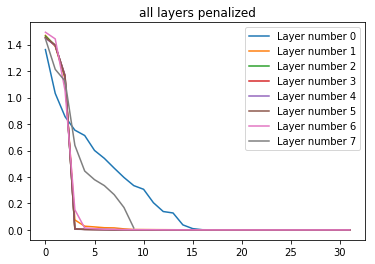

In [56]:
#With regularization
sing_vals_all = []
for (idx, weight_matrix) in enumerate(weights):
        sig = plot_singular_values(weight_matrix, idx, "all layers penalized")
        sing_vals_all.append(sig)

In [57]:
#Regular points
acts = model_all_reg.get_activation(sess_all_reg, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = model_all_reg.fgsm_np(sess_all_reg, x_test_flat, y_test, config['eps_test'])
acts_adv = model_all_reg.get_activation(sess_all_reg, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [58]:
diff_norm

[1.2381881, 1.1723968, 0.9998556, 1.2088721, 1.156904, 1.2247998]

In [59]:
diff_norm_adv

[1.2208154, 1.1831144, 1.000097, 1.2062595, 1.1468935, 1.2146919]

In [60]:
dphi_dx_robust_all_reg = reg_model.get_dphi_dx(sess_all_reg, x_test_flat)
np.mean(np.abs(dphi_dx_robust_all_reg))

0.20034555

In [61]:
dpred_dx_robust_all_reg = reg_model.get_pred_dx(sess_all_reg, x_test_flat)
np.mean(np.abs(dpred_dx_robust_all_reg))

0.0020152025

# FGSM Adversarial Training

In [62]:
#Config
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"
config['load_counter'] = 280
config['sigma'] = tf.nn.relu
config['scope_name'] = "model_robust"

In [63]:
model_rob, sess_rob = adversarial_training(config)

Adversarial Training
I0920 10:34:10.136610 4522669504 <ipython-input-8-d7d1c01af8cd>:18] Adversarial Training
Initialized instance variables of the robust model class
I0920 10:34:10.138910 4522669504 feedforward_robust.py:30] Initialized instance variables of the robust model class
Created placeholders for x and y
I0920 10:34:10.142285 4522669504 feedforward_robust.py:36] Created placeholders for x and y
Created layers and tensor for logits
I0920 10:34:10.247450 4522669504 feedforward_robust.py:40] Created layers and tensor for logits
Added loss computation to the graph
I0920 10:34:10.267226 4522669504 feedforward_robust.py:45] Added loss computation to the graph
Added accuracy computation to the graph
I0920 10:34:10.273691 4522669504 feedforward_robust.py:49] Added accuracy computation to the graph
Model graph was created
I0920 10:34:10.276664 4522669504 feedforward_robust.py:52] Model graph was created
Epoch: 0001    cost: 1.780741564 
I0920 10:34:15.523226 4522669504 feedforward_rob

(0.29955286, 0.9065)


Model is being evaluated on FGSM data
I0920 10:35:23.712548 4522669504 feedforward_robust.py:363] Model is being evaluated on FGSM data


(0.5371509, 0.8298)


In [64]:
with tf.variable_scope(config['scope_name']) as scope:
    weights_robust = model_rob.get_weights_np(sess_rob)

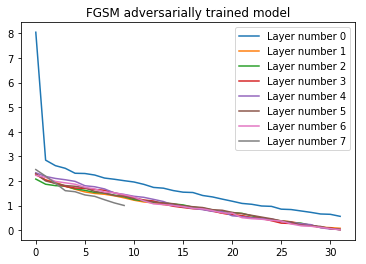

In [65]:
sing_vals_robust = []
for (idx, weight_matrix) in enumerate(weights_robust):
    sig = plot_singular_values(weight_matrix, idx, "FGSM adversarially trained model")
    sing_vals_robust.append(sig)

In [66]:
dphi_dx_robust = model_rob.get_dphi_dx(sess_rob, x_test_flat)
np.mean(np.abs(dphi_dx_robust))

0.36060256

In [67]:
dpred_dx_robust = model_rob.get_pred_dx(sess_rob, x_test_flat)
np.mean(np.abs(dpred_dx_robust))

0.16378531

In [68]:
sing_vals[0]

array([11.189289 , 10.133197 ,  9.383851 ,  8.92445  ,  8.247922 ,
        7.969636 ,  7.4290295,  7.0685034,  6.6811824,  6.1500745,
        5.970582 ,  5.6832013,  5.439685 ,  5.1961956,  5.0047846,
        4.7424994,  4.5128593,  4.3439555,  4.1835628,  3.9895031,
        3.7153032,  3.6492496,  3.417802 ,  3.3370526,  3.3204548,
        3.294197 ,  3.0694237,  2.9688969,  2.8788092,  2.7434793,
        2.6681807,  1.4231784], dtype=float32)

In [69]:
sing_vals_robust[0]

array([8.041906  , 2.8461196 , 2.6218433 , 2.5148618 , 2.3136268 ,
       2.3036385 , 2.2410057 , 2.1185622 , 2.0696816 , 2.0116315 ,
       1.9582833 , 1.8629959 , 1.7374797 , 1.7074083 , 1.6103636 ,
       1.5451897 , 1.5312704 , 1.4100131 , 1.3516164 , 1.2622443 ,
       1.1780288 , 1.0885143 , 1.0528333 , 0.98358023, 0.96882313,
       0.85465336, 0.83948094, 0.78271955, 0.7262677 , 0.6591632 ,
       0.64538497, 0.5635714 ], dtype=float32)

In [70]:
sing_vals[1]

array([3.674316  , 3.3551764 , 3.224709  , 2.9054708 , 2.6243584 ,
       2.4510684 , 2.1869967 , 2.1103704 , 1.7720344 , 1.5988731 ,
       1.4801615 , 1.421275  , 1.3496728 , 1.2716495 , 1.1624023 ,
       1.0521415 , 1.0061094 , 0.94067425, 0.904368  , 0.82833225,
       0.75014293, 0.6533072 , 0.61833286, 0.5395455 , 0.42479357,
       0.39901435, 0.33884445, 0.26813343, 0.20976494, 0.18486662,
       0.15978248, 0.03111679], dtype=float32)

In [71]:
sing_vals_robust[1]

array([2.250704  , 2.0437882 , 1.9482691 , 1.794221  , 1.6630073 ,
       1.5554217 , 1.4932556 , 1.4596395 , 1.3989106 , 1.3130281 ,
       1.2185704 , 1.1473727 , 1.111897  , 1.0392451 , 1.0151943 ,
       0.9901146 , 0.9360538 , 0.8630421 , 0.7966898 , 0.6915268 ,
       0.6416885 , 0.5846894 , 0.5079196 , 0.49544176, 0.4048659 ,
       0.37970898, 0.34276804, 0.2692391 , 0.16996233, 0.12538308,
       0.10384393, 0.07758896], dtype=float32)

In [72]:
sing_vals[2]

array([3.3668115 , 2.842233  , 2.7448304 , 2.5716846 , 2.5023568 ,
       2.3724024 , 2.2186227 , 2.019235  , 1.795118  , 1.5796243 ,
       1.4817913 , 1.4066254 , 1.3463677 , 1.25288   , 1.2033571 ,
       1.0469009 , 1.0039477 , 0.91686976, 0.8075825 , 0.76937425,
       0.758841  , 0.63528323, 0.55939764, 0.49177903, 0.47970247,
       0.3502487 , 0.29832286, 0.24977762, 0.20475344, 0.14861573,
       0.07453168, 0.01873747], dtype=float32)

In [73]:
sing_vals_robust[2]

array([2.0772789 , 1.8680423 , 1.8104529 , 1.7884196 , 1.6791902 ,
       1.6208174 , 1.5342655 , 1.5083755 , 1.4238051 , 1.3565916 ,
       1.243515  , 1.1923367 , 1.1349438 , 1.110976  , 1.0678301 ,
       1.0277395 , 0.93590415, 0.89728415, 0.82366335, 0.74510854,
       0.7147365 , 0.6856351 , 0.58394897, 0.5004991 , 0.42086664,
       0.37986872, 0.30182996, 0.28760907, 0.20159066, 0.11772406,
       0.08059862, 0.01785877], dtype=float32)

In [74]:
sing_vals[-1]

array([2.3056653 , 2.0326595 , 1.8763782 , 1.7655128 , 1.5709738 ,
       1.3455315 , 1.2124654 , 0.9837641 , 0.81992024, 0.6042539 ],
      dtype=float32)

In [75]:
sing_vals_robust[-1]

array([2.4634867, 2.195266 , 1.9086281, 1.6059831, 1.5634149, 1.4329724,
       1.3754187, 1.2376448, 1.1088507, 1.0046979], dtype=float32)

In [76]:
#Regular points
acts = model_rob.get_activation(sess_rob, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = model_rob.fgsm_np(sess_rob, x_test_flat, y_test, config['eps_test'])
acts_adv = model_rob.get_activation(sess_rob, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [77]:
diff_norm

[1.1161737, 1.1082828, 1.0896318, 1.0252649, 1.2063043, 1.193971]

In [78]:
diff_norm_adv

[1.1470771, 1.0691653, 1.044598, 0.98992586, 1.1713406, 1.1420324]

# Comparison plots

## Distances

In [79]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

In [80]:
#make_dist_plot_all_models(model_list, sess_list, scope_list, legend_list, order = 2)

In [81]:
#make_dist_plot_all_models(model_list, sess_list, scope_list, legend_list, order = float("inf"))

## Stats

In [82]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]

In [83]:
reg_evals, adv_evals, margins, dphi_dxs = get_stats_all_models(model_list, sess_list, scope_list)

Model was evaluated on benign data
I0920 10:35:26.746192 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model is being evaluated on FGSM data
I0920 10:35:27.040690 4522669504 feedforward_robust.py:363] Model is being evaluated on FGSM data
Obtained featurizations
I0920 10:35:27.071220 4522669504 feedforward_robust.py:216] Obtained featurizations
Created feat adv graph
I0920 10:35:27.241405 4522669504 feedforward_robust.py:224] Created feat adv graph


iteration: 0
loss 0.256710
iteration: 1
loss 0.333260
iteration: 2
loss 0.424758
iteration: 3
loss 0.531791
iteration: 4
loss 0.654261
iteration: 5
loss 0.791476
iteration: 6
loss 0.941458
iteration: 7
loss 1.101837
iteration: 8
loss 1.269225
iteration: 9
loss 1.440014
iteration: 10
loss 1.609863
iteration: 11
loss 1.774478
iteration: 12
loss 1.930429
iteration: 13
loss 2.074095
iteration: 14
loss 2.202137
iteration: 15
loss 2.311767
iteration: 16
loss 2.400628
iteration: 17
loss 2.467019
iteration: 18
loss 2.509734
iteration: 19
loss 2.527860
iteration: 20
loss 2.533504
iteration: 21
loss 2.538811
iteration: 22
loss 2.543754
iteration: 23
loss 2.548359
iteration: 24
loss 2.552631
iteration: 25
loss 2.556636
iteration: 26
loss 2.560359
iteration: 27
loss 2.563817
iteration: 28
loss 2.566992
iteration: 29
loss 2.569904
iteration: 30
loss 2.572544
iteration: 31
loss 2.574935
iteration: 32
loss 2.577110
iteration: 33
loss 2.579056
iteration: 34
loss 2.580802
iteration: 35
loss 2.582393
it

Found adversarial featurizations
I0920 10:35:28.505340 4522669504 feedforward_robust.py:219] Found adversarial featurizations
Model was evaluated from featurizations
I0920 10:35:28.508858 4522669504 feedforward_robust.py:383] Model was evaluated from featurizations


loss 2.596740
iteration: 186
loss 2.596740
iteration: 187
loss 2.596740
iteration: 188
loss 2.596740
iteration: 189
loss 2.596740
iteration: 190
loss 2.596740
iteration: 191
loss 2.596740
iteration: 192
loss 2.596740
iteration: 193
loss 2.596740
iteration: 194
loss 2.596740
iteration: 195
loss 2.596740
iteration: 196
loss 2.596740
iteration: 197
loss 2.596740
iteration: 198
loss 2.596740
iteration: 199
loss 2.596740


Model was evaluated on benign data
I0920 10:35:28.803591 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model is being evaluated on FGSM data
I0920 10:35:29.097791 4522669504 feedforward_robust.py:363] Model is being evaluated on FGSM data
Obtained featurizations
I0920 10:35:29.208949 4522669504 feedforward_robust.py:216] Obtained featurizations
Created feat adv graph
I0920 10:35:29.376366 4522669504 feedforward_robust.py:224] Created feat adv graph


iteration: 0
loss 0.581230
iteration: 1
loss 0.669893
iteration: 2
loss 0.763481
iteration: 3
loss 0.860889
iteration: 4
loss 0.960838
iteration: 5
loss 1.062152
iteration: 6
loss 1.163276
iteration: 7
loss 1.263136
iteration: 8
loss 1.360305
iteration: 9
loss 1.453457
iteration: 10
loss 1.541487
iteration: 11
loss 1.623300
iteration: 12
loss 1.697855
iteration: 13
loss 1.764364
iteration: 14
loss 1.822188
iteration: 15
loss 1.870632
iteration: 16
loss 1.909287
iteration: 17
loss 1.937713
iteration: 18
loss 1.955546
iteration: 19
loss 1.962655
iteration: 20
loss 1.964429
iteration: 21
loss 1.966138
iteration: 22
loss 1.967768
iteration: 23
loss 1.969299
iteration: 24
loss 1.970752
iteration: 25
loss 1.972135
iteration: 26
loss 1.973415
iteration: 27
loss 1.974591
iteration: 28
loss 1.975680
iteration: 29
loss 1.976684
iteration: 30
loss 1.977596
iteration: 31
loss 1.978402
iteration: 32
loss 1.979119
iteration: 33
loss 1.979751
iteration: 34
loss 1.980304
iteration: 35
loss 1.980785
it

Found adversarial featurizations
I0920 10:35:30.828197 4522669504 feedforward_robust.py:219] Found adversarial featurizations
Model was evaluated from featurizations
I0920 10:35:30.864161 4522669504 feedforward_robust.py:383] Model was evaluated from featurizations


loss 1.984672
iteration: 193
loss 1.984672
iteration: 194
loss 1.984672
iteration: 195
loss 1.984672
iteration: 196
loss 1.984672
iteration: 197
loss 1.984672
iteration: 198
loss 1.984672
iteration: 199
loss 1.984672


Model was evaluated on benign data
I0920 10:35:31.177414 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model is being evaluated on FGSM data
I0920 10:35:31.496591 4522669504 feedforward_robust.py:363] Model is being evaluated on FGSM data
Obtained featurizations
I0920 10:35:31.615962 4522669504 feedforward_robust.py:216] Obtained featurizations
Created feat adv graph
I0920 10:35:31.816269 4522669504 feedforward_robust.py:224] Created feat adv graph


iteration: 0
loss 0.598878
iteration: 1
loss 0.873566
iteration: 2
loss 1.208645
iteration: 3
loss 1.597431
iteration: 4
loss 2.028765
iteration: 5
loss 2.488375
iteration: 6
loss 2.962822
iteration: 7
loss 3.438711
iteration: 8
loss 3.903599
iteration: 9
loss 4.346443
iteration: 10
loss 4.759498
iteration: 11
loss 5.137807
iteration: 12
loss 5.477465
iteration: 13
loss 5.776179
iteration: 14
loss 6.031555
iteration: 15
loss 6.243080
iteration: 16
loss 6.410439
iteration: 17
loss 6.533760
iteration: 18
loss 6.613559
iteration: 19
loss 6.649303
iteration: 20
loss 6.663283
iteration: 21
loss 6.676630
iteration: 22
loss 6.689268
iteration: 23
loss 6.701140
iteration: 24
loss 6.712235
iteration: 25
loss 6.722467
iteration: 26
loss 6.731915
iteration: 27
loss 6.740607
iteration: 28
loss 6.748625
iteration: 29
loss 6.755960
iteration: 30
loss 6.762570
iteration: 31
loss 6.768591
iteration: 32
loss 6.773950
iteration: 33
loss 6.778760
iteration: 34
loss 6.783038
iteration: 35
loss 6.786857
it

Found adversarial featurizations
I0920 10:35:33.418605 4522669504 feedforward_robust.py:219] Found adversarial featurizations
Model was evaluated from featurizations
I0920 10:35:33.461746 4522669504 feedforward_robust.py:383] Model was evaluated from featurizations
Model was evaluated on benign data
I0920 10:35:33.811779 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model is being evaluated on FGSM data
I0920 10:35:34.138578 4522669504 feedforward_robust.py:363] Model is being evaluated on FGSM data
Obtained featurizations
I0920 10:35:34.252634 4522669504 feedforward_robust.py:216] Obtained featurizations
Created feat adv graph
I0920 10:35:34.436186 4522669504 feedforward_robust.py:224] Created feat adv graph


iteration: 0
loss 1.365952
iteration: 1
loss 1.952576
iteration: 2
loss 2.640152
iteration: 3
loss 3.398195
iteration: 4
loss 4.193830
iteration: 5
loss 4.997369
iteration: 6
loss 5.785408
iteration: 7
loss 6.541226
iteration: 8
loss 7.252316
iteration: 9
loss 7.910245
iteration: 10
loss 8.509381
iteration: 11
loss 9.047505
iteration: 12
loss 9.522912
iteration: 13
loss 9.936598
iteration: 14
loss 10.288236
iteration: 15
loss 10.577937
iteration: 16
loss 10.806539
iteration: 17
loss 10.974925
iteration: 18
loss 11.085087
iteration: 19
loss 11.137502
iteration: 20
loss 11.159999
iteration: 21
loss 11.181129
iteration: 22
loss 11.200783
iteration: 23
loss 11.219017
iteration: 24
loss 11.235881
iteration: 25
loss 11.251476
iteration: 26
loss 11.265821
iteration: 27
loss 11.278950
iteration: 28
loss 11.291031
iteration: 29
loss 11.302192
iteration: 30
loss 11.312256
iteration: 31
loss 11.321433
iteration: 32
loss 11.329828
iteration: 33
loss 11.337269
iteration: 34
loss 11.343886
iteration

Found adversarial featurizations
I0920 10:35:35.977638 4522669504 feedforward_robust.py:219] Found adversarial featurizations
Model was evaluated from featurizations
I0920 10:35:36.019988 4522669504 feedforward_robust.py:383] Model was evaluated from featurizations


loss 11.404331
iteration: 186
loss 11.404331
iteration: 187
loss 11.404331
iteration: 188
loss 11.404331
iteration: 189
loss 11.404331
iteration: 190
loss 11.404331
iteration: 191
loss 11.404331
iteration: 192
loss 11.404331
iteration: 193
loss 11.404331
iteration: 194
loss 11.404331
iteration: 195
loss 11.404331
iteration: 196
loss 11.404331
iteration: 197
loss 11.404331
iteration: 198
loss 11.404331
iteration: 199
loss 11.404331


Model was evaluated on benign data
I0920 10:35:36.341433 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model is being evaluated on FGSM data
I0920 10:35:36.841588 4522669504 feedforward_robust.py:363] Model is being evaluated on FGSM data
Obtained featurizations
I0920 10:35:36.958997 4522669504 feedforward_robust.py:216] Obtained featurizations
Created feat adv graph
I0920 10:35:37.123938 4522669504 feedforward_robust.py:224] Created feat adv graph


iteration: 0
loss 0.903594
iteration: 1
loss 1.381284
iteration: 2
loss 1.982199
iteration: 3
loss 2.690637
iteration: 4
loss 3.478391
iteration: 5
loss 4.311230
iteration: 6
loss 5.157334
iteration: 7
loss 5.989583
iteration: 8
loss 6.787470
iteration: 9
loss 7.536408
iteration: 10
loss 8.226810
iteration: 11
loss 8.853973
iteration: 12
loss 9.413434
iteration: 13
loss 9.904429
iteration: 14
loss 10.325733
iteration: 15
loss 10.677395
iteration: 16
loss 10.958947
iteration: 17
loss 11.171235
iteration: 18
loss 11.314735
iteration: 19
loss 11.390390
iteration: 20
loss 11.430924
iteration: 21
loss 11.468988
iteration: 22
loss 11.504444
iteration: 23
loss 11.537533
iteration: 24
loss 11.568595
iteration: 25
loss 11.597376
iteration: 26
loss 11.624178
iteration: 27
loss 11.648989
iteration: 28
loss 11.671925
iteration: 29
loss 11.693089
iteration: 30
loss 11.712694
iteration: 31
loss 11.730501
iteration: 32
loss 11.746614
iteration: 33
loss 11.760977
iteration: 34
loss 11.773764
iteration

Found adversarial featurizations
I0920 10:35:38.465882 4522669504 feedforward_robust.py:219] Found adversarial featurizations
Model was evaluated from featurizations
I0920 10:35:38.528021 4522669504 feedforward_robust.py:383] Model was evaluated from featurizations


loss 11.868343
iteration: 185
loss 11.868343
iteration: 186
loss 11.868343
iteration: 187
loss 11.868343
iteration: 188
loss 11.868343
iteration: 189
loss 11.868343
iteration: 190
loss 11.868343
iteration: 191
loss 11.868343
iteration: 192
loss 11.868343
iteration: 193
loss 11.868343
iteration: 194
loss 11.868343
iteration: 195
loss 11.868343
iteration: 196
loss 11.868343
iteration: 197
loss 11.868343
iteration: 198
loss 11.868343
iteration: 199
loss 11.868343


In [84]:
#model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model

In [85]:
reg_evals

[(0.17380294, 0.9559),
 (0.4752624, 0.8653),
 (0.29955286, 0.9065),
 (0.6153447, 0.8071),
 (0.3424165, 0.8982)]

In [86]:
adv_evals

[(6.6653485, 0.0579),
 (3.4028633, 0.1185),
 (0.5371509, 0.8298),
 (2.5958252, 0.362),
 (3.3301492, 0.3424)]

In [87]:
dphi_dxs

[0.8664375, 0.20034555, 0.36060256, 0.39415258, 0.29407898]

In [88]:
margins

[0.3247, 0.2878, 0.001, 0.0035, 0.0238]

In [89]:
labels = ['non robust', 'Sing val all', 'fgsm train', 'hybrid', 'sing val first']

In [90]:
adv_evals_np = np.array(adv_evals)
acc_adv = adv_evals_np[:, 1]

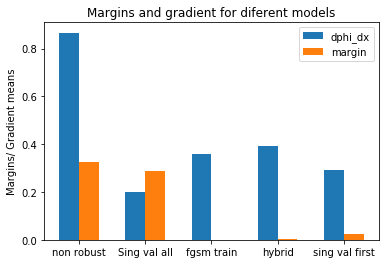

[0.0579 0.1185 0.8298 0.362  0.3424]


In [91]:
x = 2*np.arange(len(labels))  # the label locations
width = 0.60  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dphi_dxs, width, label='dphi_dx')
rects2 = ax.bar(x + width/2, margins, width, label='margin')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Margins/ Gradient means')
ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()
print(adv_evals_np[:, 1])

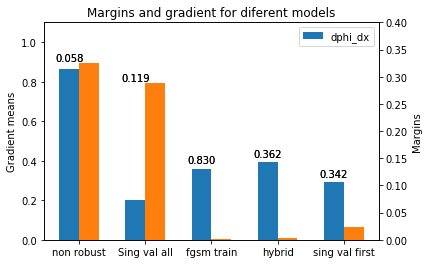

[0.0579 0.1185 0.8298 0.362  0.3424]


In [92]:
x = 2*np.arange(len(labels))  # the label locations
width = 0.60  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dphi_dxs, width, label='dphi_dx')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Gradient means')
ax.set_ylim((0, 1.1))
ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


color = 'tab:orange'
ax2 = ax.twinx()
rects2 = ax2.bar(x + width/2, margins, width, label='margin', color = color)
ax2.set_ylabel('Margins')
ax2.set_ylim((0, 0.40))
#ax.set_xticks(x)
#ax.set_xticklabels(labels)
#ax2.legend(legend_loc = (1.0, 0.8))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for (idx, rect) in enumerate(rects1):
        height = rect.get_height()
        height_2 = rects2[idx].get_height() * (1.0/0.37)
        height = max(height, height_2)
        ax.annotate('{:0.3f}'.format(acc_adv[idx]),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

plt.show()
print(adv_evals_np[:, 1])

## Accuracies 

In [93]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
eps_list = [0, 0.02, 0.05, 0.1, 0.2, 0.3]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non_robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

In [94]:
#make_plot_acc_vs_eps(model_list, sess_list, eps_list, legend_list, scope_list, pgd = False)

In [95]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
eps_list = [0, 0.02, 0.05, 0.1, 0.2, 0.3]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non_robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:35:39.798797 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.173803
iteration: 1
loss 0.173803
iteration: 2
loss 0.173803
iteration: 3
loss 0.173803
iteration: 4
loss 0.173803
iteration: 5
loss 0.173803
iteration: 6
loss 0.173803
iteration: 7
loss 0.173803
iteration: 8
loss 0.173803
iteration: 9
loss 0.173803
iteration: 10
loss 0.173803
iteration: 11
loss 0.173803
iteration: 12
loss 0.173803
iteration: 13
loss 0.173803
iteration: 14
loss 0.173803
iteration: 15
loss 0.173803
iteration: 16
loss 0.173803
iteration: 17
loss 0.173803
iteration: 18
loss 0.173803
iteration: 19
loss 0.173803
iteration: 20
loss 0.173803
iteration: 21
loss 0.173803
iteration: 22
loss 0.173803
iteration: 23
loss 0.173803
iteration: 24
loss 0.173803
iteration: 25
loss 0.173803
iteration: 26
loss 0.173803
iteration: 27
loss 0.173803
iteration: 28
loss 0.173803
iteration: 29
loss 0.173803
iteration: 30
loss 0.173803
iteration: 31
loss 0.173803
iteration: 32
loss 0.173803
iteration: 33
loss 0.173803
iteration: 34
loss 0.173803
iteration: 35
loss 0.173803
it

This is to confirm that attack does not violate constraints
I0920 10:35:45.214538 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:35:45.215804 4522669504 feedforward_robust.py:210] Should be no more than eps
2.9685450542160652e-08
I0920 10:35:45.259676 4522669504 feedforward_robust.py:211] 2.9685450542160652e-08
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:35:45.278700 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.378418
iteration: 1
loss 0.641930
iteration: 2
loss 0.881962
iteration: 3
loss 1.011289
iteration: 4
loss 1.056395
iteration: 5
loss 1.084244
iteration: 6
loss 1.099564
iteration: 7
loss 1.107820
iteration: 8
loss 1.113029
iteration: 9
loss 1.116073
iteration: 10
loss 1.118290
iteration: 11
loss 1.119743
iteration: 12
loss 1.120327
iteration: 13
loss 1.120887
iteration: 14
loss 1.121516
iteration: 15
loss 1.121830
iteration: 16
loss 1.122303
iteration: 17
loss 1.122148
iteration: 18
loss 1.122467
iteration: 19
loss 1.122544
iteration: 20
loss 1.122825
iteration: 21
loss 1.122571
iteration: 22
loss 1.122857
iteration: 23
loss 1.122651
iteration: 24
loss 1.122815
iteration: 25
loss 1.122461
iteration: 26
loss 1.122980
iteration: 27
loss 1.122782
iteration: 28
loss 1.122844
iteration: 29
loss 1.122470
iteration: 30
loss 1.122888
iteration: 31
loss 1.122828
iteration: 32
loss 1.122810
iteration: 33
loss 1.122465
iteration: 34
loss 1.122871
iteration: 35
loss 1.122800
it

This is to confirm that attack does not violate constraints
I0920 10:35:50.703397 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:35:50.708936 4522669504 feedforward_robust.py:210] Should be no more than eps


loss 1.122513


0.020000041699877014
I0920 10:35:50.913294 4522669504 feedforward_robust.py:211] 0.020000041699877014
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:35:50.954766 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.405117
iteration: 1
loss 0.803994
iteration: 2
loss 1.357127
iteration: 3
loss 2.022068
iteration: 4
loss 2.730806
iteration: 5
loss 3.405641
iteration: 6
loss 4.011405
iteration: 7
loss 4.520402
iteration: 8
loss 4.922749
iteration: 9
loss 5.188517
iteration: 10
loss 5.380383
iteration: 11
loss 5.535499
iteration: 12
loss 5.666282
iteration: 13
loss 5.769759
iteration: 14
loss 5.853350
iteration: 15
loss 5.918271
iteration: 16
loss 5.968703
iteration: 17
loss 6.004847
iteration: 18
loss 6.038191
iteration: 19
loss 6.058459
iteration: 20
loss 6.081401
iteration: 21
loss 6.093334
iteration: 22
loss 6.111878
iteration: 23
loss 6.118004
iteration: 24
loss 6.131584
iteration: 25
loss 6.137145
iteration: 26
loss 6.145847
iteration: 27
loss 6.150097
iteration: 28
loss 6.156059
iteration: 29
loss 6.160429
iteration: 30
loss 6.163823
iteration: 31
loss 6.167049
iteration: 32
loss 6.169897
iteration: 33
loss 6.173729
iteration: 34
loss 6.176932
iteration: 35
loss 6.177979
it

This is to confirm that attack does not violate constraints
I0920 10:35:56.589493 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:35:56.591953 4522669504 feedforward_robust.py:210] Should be no more than eps
0.0500000416063795
I0920 10:35:56.664458 4522669504 feedforward_robust.py:211] 0.0500000416063795
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:35:56.684016 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.429292
iteration: 1
loss 0.883066
iteration: 2
loss 1.570417
iteration: 3
loss 2.466992
iteration: 4
loss 3.485358
iteration: 5
loss 4.537111
iteration: 6
loss 5.569323
iteration: 7
loss 6.557558
iteration: 8
loss 7.488179
iteration: 9
loss 8.361223
iteration: 10
loss 9.178257
iteration: 11
loss 9.947466
iteration: 12
loss 10.659415
iteration: 13
loss 11.313869
iteration: 14
loss 11.912103
iteration: 15
loss 12.453037
iteration: 16
loss 12.928443
iteration: 17
loss 13.342067
iteration: 18
loss 13.691563
iteration: 19
loss 13.979279
iteration: 20
loss 14.215817
iteration: 21
loss 14.429678
iteration: 22
loss 14.609806
iteration: 23
loss 14.769750
iteration: 24
loss 14.903563
iteration: 25
loss 15.023484
iteration: 26
loss 15.119528
iteration: 27
loss 15.204042
iteration: 28
loss 15.272079
iteration: 29
loss 15.332538
iteration: 30
loss 15.384440
iteration: 31
loss 15.429922
iteration: 32
loss 15.469504
iteration: 33
loss 15.504423
iteration: 34
loss 15.533778
iterati

This is to confirm that attack does not violate constraints
I0920 10:36:02.195751 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:36:02.198813 4522669504 feedforward_robust.py:210] Should be no more than eps
0.10000005352730845
I0920 10:36:02.359339 4522669504 feedforward_robust.py:211] 0.10000005352730845
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:36:02.380872 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.481097
iteration: 1
loss 1.011209
iteration: 2
loss 1.820826
iteration: 3
loss 2.868406
iteration: 4
loss 4.041942
iteration: 5
loss 5.265430
iteration: 6
loss 6.473970
iteration: 7
loss 7.666384
iteration: 8
loss 8.828745
iteration: 9
loss 9.957469
iteration: 10
loss 11.055597
iteration: 11
loss 12.128390
iteration: 12
loss 13.176125
iteration: 13
loss 14.195746
iteration: 14
loss 15.189702
iteration: 15
loss 16.158958
iteration: 16
loss 17.097305
iteration: 17
loss 18.008678
iteration: 18
loss 18.894863
iteration: 19
loss 19.752453
iteration: 20
loss 20.585268
iteration: 21
loss 21.388063
iteration: 22
loss 22.162659
iteration: 23
loss 22.907511
iteration: 24
loss 23.621485
iteration: 25
loss 24.307507
iteration: 26
loss 24.961323
iteration: 27
loss 25.584600
iteration: 28
loss 26.176472
iteration: 29
loss 26.735737
iteration: 30
loss 27.262972
iteration: 31
loss 27.756399
iteration: 32
loss 28.218019
iteration: 33
loss 28.645124
iteration: 34
loss 29.040865
itera

This is to confirm that attack does not violate constraints
I0920 10:36:07.728203 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:36:07.730195 4522669504 feedforward_robust.py:210] Should be no more than eps
0.20000005937090104
I0920 10:36:07.823876 4522669504 feedforward_robust.py:211] 0.20000005937090104
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:36:07.843696 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.585127
iteration: 1
loss 1.199560
iteration: 2
loss 2.099000
iteration: 3
loss 3.222634
iteration: 4
loss 4.470878
iteration: 5
loss 5.775253
iteration: 6
loss 7.081954
iteration: 7
loss 8.363015
iteration: 8
loss 9.613884
iteration: 9
loss 10.839907
iteration: 10
loss 12.046290
iteration: 11
loss 13.231795
iteration: 12
loss 14.394095
iteration: 13
loss 15.533203
iteration: 14
loss 16.655668
iteration: 15
loss 17.763128
iteration: 16
loss 18.855486
iteration: 17
loss 19.928299
iteration: 18
loss 20.988558
iteration: 19
loss 22.030710
iteration: 20
loss 23.060492
iteration: 21
loss 24.070513
iteration: 22
loss 25.065748
iteration: 23
loss 26.043344
iteration: 24
loss 27.002987
iteration: 25
loss 27.942968
iteration: 26
loss 28.864500
iteration: 27
loss 29.766912
iteration: 28
loss 30.650122
iteration: 29
loss 31.513971
iteration: 30
loss 32.358009
iteration: 31
loss 33.182549
iteration: 32
loss 33.987064
iteration: 33
loss 34.769661
iteration: 34
loss 35.531399
iter

This is to confirm that attack does not violate constraints
I0920 10:36:12.845468 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:36:12.846951 4522669504 feedforward_robust.py:210] Should be no more than eps
0.30000008882260787
I0920 10:36:12.912053 4522669504 feedforward_robust.py:211] 0.30000008882260787
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:36:12.943493 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.475262
iteration: 1
loss 0.475262
iteration: 2
loss 0.475262
iteration: 3
loss 0.475262
iteration: 4
loss 0.475262
iteration: 5
loss 0.475262
iteration: 6
loss 0.475262
iteration: 7
loss 0.475262
iteration: 8
loss 0.475262
iteration: 9
loss 0.475262
iteration: 10
loss 0.475262
iteration: 11
loss 0.475262
iteration: 12
loss 0.475262
iteration: 13
loss 0.475262
iteration: 14
loss 0.475262
iteration: 15
loss 0.475262
iteration: 16
loss 0.475262
iteration: 17
loss 0.475262
iteration: 18
loss 0.475262
iteration: 19
loss 0.475262
iteration: 20
loss 0.475262
iteration: 21
loss 0.475262
iteration: 22
loss 0.475262
iteration: 23
loss 0.475262
iteration: 24
loss 0.475262
iteration: 25
loss 0.475262
iteration: 26
loss 0.475262
iteration: 27
loss 0.475262
iteration: 28
loss 0.475262
iteration: 29
loss 0.475262
iteration: 30
loss 0.475262
iteration: 31
loss 0.475262
iteration: 32
loss 0.475262
iteration: 33
loss 0.475262
iteration: 34
loss 0.475262
iteration: 35
loss 0.475262
it

This is to confirm that attack does not violate constraints
I0920 10:36:18.534906 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:36:18.536013 4522669504 feedforward_robust.py:210] Should be no more than eps
2.9685450542160652e-08
I0920 10:36:18.578128 4522669504 feedforward_robust.py:211] 2.9685450542160652e-08
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:36:18.599290 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.597999
iteration: 1
loss 0.704590
iteration: 2
loss 0.777693
iteration: 3
loss 0.804723
iteration: 4
loss 0.806049
iteration: 5
loss 0.806770
iteration: 6
loss 0.807081
iteration: 7
loss 0.807231
iteration: 8
loss 0.807273
iteration: 9
loss 0.807335
iteration: 10
loss 0.807339
iteration: 11
loss 0.807383
iteration: 12
loss 0.807376
iteration: 13
loss 0.807414
iteration: 14
loss 0.807404
iteration: 15
loss 0.807434
iteration: 16
loss 0.807408
iteration: 17
loss 0.807447
iteration: 18
loss 0.807417
iteration: 19
loss 0.807446
iteration: 20
loss 0.807422
iteration: 21
loss 0.807457
iteration: 22
loss 0.807427
iteration: 23
loss 0.807453
iteration: 24
loss 0.807429
iteration: 25
loss 0.807463
iteration: 26
loss 0.807434
iteration: 27
loss 0.807459
iteration: 28
loss 0.807434
iteration: 29
loss 0.807468
iteration: 30
loss 0.807436
iteration: 31
loss 0.807462
iteration: 32
loss 0.807435
iteration: 33
loss 0.807468
iteration: 34
loss 0.807437
iteration: 35
loss 0.807462
it

This is to confirm that attack does not violate constraints
I0920 10:36:23.876994 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:36:23.878109 4522669504 feedforward_robust.py:210] Should be no more than eps
0.020000041699877014
I0920 10:36:23.919250 4522669504 feedforward_robust.py:211] 0.020000041699877014
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:36:23.939920 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.610397
iteration: 1
loss 0.761964
iteration: 2
loss 0.923199
iteration: 3
loss 1.086062
iteration: 4
loss 1.241540
iteration: 5
loss 1.381657
iteration: 6
loss 1.499289
iteration: 7
loss 1.589380
iteration: 8
loss 1.647891
iteration: 9
loss 1.672180
iteration: 10
loss 1.678220
iteration: 11
loss 1.682885
iteration: 12
loss 1.686541
iteration: 13
loss 1.689229
iteration: 14
loss 1.691397
iteration: 15
loss 1.692920
iteration: 16
loss 1.694154
iteration: 17
loss 1.694969
iteration: 18
loss 1.695665
iteration: 19
loss 1.696104
iteration: 20
loss 1.696539
iteration: 21
loss 1.696883
iteration: 22
loss 1.697227
iteration: 23
loss 1.697450
iteration: 24
loss 1.697674
iteration: 25
loss 1.697874
iteration: 26
loss 1.698055
iteration: 27
loss 1.698213
iteration: 28
loss 1.698330
iteration: 29
loss 1.698456
iteration: 30
loss 1.698554
iteration: 31
loss 1.698641
iteration: 32
loss 1.698733
iteration: 33
loss 1.698798
iteration: 34
loss 1.698853
iteration: 35
loss 1.698909
it

This is to confirm that attack does not violate constraints
I0920 10:36:29.226097 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:36:29.227447 4522669504 feedforward_robust.py:210] Should be no more than eps
0.0500000416063795
I0920 10:36:29.270764 4522669504 feedforward_robust.py:211] 0.0500000416063795
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:36:29.290486 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.617714
iteration: 1
loss 0.785793
iteration: 2
loss 0.981398
iteration: 3
loss 1.200191
iteration: 4
loss 1.436763
iteration: 5
loss 1.683939
iteration: 6
loss 1.934796
iteration: 7
loss 2.183393
iteration: 8
loss 2.424329
iteration: 9
loss 2.654158
iteration: 10
loss 2.869892
iteration: 11
loss 3.069347
iteration: 12
loss 3.250785
iteration: 13
loss 3.412752
iteration: 14
loss 3.554818
iteration: 15
loss 3.675837
iteration: 16
loss 3.775383
iteration: 17
loss 3.852428
iteration: 18
loss 3.906921
iteration: 19
loss 3.937766
iteration: 20
loss 3.956205
iteration: 21
loss 3.972255
iteration: 22
loss 3.987129
iteration: 23
loss 4.000054
iteration: 24
loss 4.011895
iteration: 25
loss 4.022065
iteration: 26
loss 4.031453
iteration: 27
loss 4.039270
iteration: 28
loss 4.046391
iteration: 29
loss 4.052331
iteration: 30
loss 4.057774
iteration: 31
loss 4.062094
iteration: 32
loss 4.066236
iteration: 33
loss 4.069413
iteration: 34
loss 4.072491
iteration: 35
loss 4.074812
it

This is to confirm that attack does not violate constraints
I0920 10:36:34.576559 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:36:34.577710 4522669504 feedforward_robust.py:210] Should be no more than eps
0.10000005352730845
I0920 10:36:34.620784 4522669504 feedforward_robust.py:211] 0.10000005352730845
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:36:34.640334 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.634066
iteration: 1
loss 0.813048
iteration: 2
loss 1.028141
iteration: 3
loss 1.278249
iteration: 4
loss 1.559026
iteration: 5
loss 1.864650
iteration: 6
loss 2.188958
iteration: 7
loss 2.524646
iteration: 8
loss 2.865101
iteration: 9
loss 3.206604
iteration: 10
loss 3.545963
iteration: 11
loss 3.881721
iteration: 12
loss 4.211731
iteration: 13
loss 4.534781
iteration: 14
loss 4.850213
iteration: 15
loss 5.157489
iteration: 16
loss 5.456377
iteration: 17
loss 5.745966
iteration: 18
loss 6.025749
iteration: 19
loss 6.295614
iteration: 20
loss 6.555420
iteration: 21
loss 6.804477
iteration: 22
loss 7.043212
iteration: 23
loss 7.270743
iteration: 24
loss 7.487413
iteration: 25
loss 7.692853
iteration: 26
loss 7.888216
iteration: 27
loss 8.072411
iteration: 28
loss 8.244760
iteration: 29
loss 8.407146
iteration: 30
loss 8.558039
iteration: 31
loss 8.698091
iteration: 32
loss 8.827044
iteration: 33
loss 8.945220
iteration: 34
loss 9.051523
iteration: 35
loss 9.147489
it

This is to confirm that attack does not violate constraints
I0920 10:36:39.948110 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:36:39.949265 4522669504 feedforward_robust.py:210] Should be no more than eps
0.20000005937090104
I0920 10:36:39.991950 4522669504 feedforward_robust.py:211] 0.20000005937090104
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:36:40.011650 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.653244
iteration: 1
loss 0.839222
iteration: 2
loss 1.064424
iteration: 3
loss 1.328550
iteration: 4
loss 1.628139
iteration: 5
loss 1.956755
iteration: 6
loss 2.307477
iteration: 7
loss 2.673157
iteration: 8
loss 3.047735
iteration: 9
loss 3.426104
iteration: 10
loss 3.806055
iteration: 11
loss 4.184946
iteration: 12
loss 4.561689
iteration: 13
loss 4.935296
iteration: 14
loss 5.305344
iteration: 15
loss 5.670372
iteration: 16
loss 6.029313
iteration: 17
loss 6.380761
iteration: 18
loss 6.724663
iteration: 19
loss 7.060069
iteration: 20
loss 7.387781
iteration: 21
loss 7.706672
iteration: 22
loss 8.017105
iteration: 23
loss 8.316906
iteration: 24
loss 8.607158
iteration: 25
loss 8.887302
iteration: 26
loss 9.158314
iteration: 27
loss 9.419557
iteration: 28
loss 9.671806
iteration: 29
loss 9.915067
iteration: 30
loss 10.149792
iteration: 31
loss 10.376427
iteration: 32
loss 10.595744
iteration: 33
loss 10.807396
iteration: 34
loss 11.011172
iteration: 35
loss 11.207

This is to confirm that attack does not violate constraints
I0920 10:36:45.367695 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:36:45.369035 4522669504 feedforward_robust.py:210] Should be no more than eps
0.30000008882260787
I0920 10:36:45.457828 4522669504 feedforward_robust.py:211] 0.30000008882260787
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:36:45.480654 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.299553
iteration: 1
loss 0.299553
iteration: 2
loss 0.299553
iteration: 3
loss 0.299553
iteration: 4
loss 0.299553
iteration: 5
loss 0.299553
iteration: 6
loss 0.299553
iteration: 7
loss 0.299553
iteration: 8
loss 0.299553
iteration: 9
loss 0.299553
iteration: 10
loss 0.299553
iteration: 11
loss 0.299553
iteration: 12
loss 0.299553
iteration: 13
loss 0.299553
iteration: 14
loss 0.299553
iteration: 15
loss 0.299553
iteration: 16
loss 0.299553
iteration: 17
loss 0.299553
iteration: 18
loss 0.299553
iteration: 19
loss 0.299553
iteration: 20
loss 0.299553
iteration: 21
loss 0.299553
iteration: 22
loss 0.299553
iteration: 23
loss 0.299553
iteration: 24
loss 0.299553
iteration: 25
loss 0.299553
iteration: 26
loss 0.299553
iteration: 27
loss 0.299553
iteration: 28
loss 0.299553
iteration: 29
loss 0.299553
iteration: 30
loss 0.299553
iteration: 31
loss 0.299553
iteration: 32
loss 0.299553
iteration: 33
loss 0.299553
iteration: 34
loss 0.299553
iteration: 35
loss 0.299553
it

This is to confirm that attack does not violate constraints
I0920 10:36:50.916954 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:36:50.918428 4522669504 feedforward_robust.py:210] Should be no more than eps
2.9685450542160652e-08
I0920 10:36:51.006800 4522669504 feedforward_robust.py:211] 2.9685450542160652e-08
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:36:51.026912 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.389210
iteration: 1
loss 0.454442
iteration: 2
loss 0.496379
iteration: 3
loss 0.515072
iteration: 4
loss 0.520622
iteration: 5
loss 0.524088
iteration: 6
loss 0.525096
iteration: 7
loss 0.525726
iteration: 8
loss 0.526199
iteration: 9
loss 0.526658
iteration: 10
loss 0.526544
iteration: 11
loss 0.526657
iteration: 12
loss 0.526478
iteration: 13
loss 0.526904
iteration: 14
loss 0.526691
iteration: 15
loss 0.526651
iteration: 16
loss 0.526832
iteration: 17
loss 0.527048
iteration: 18
loss 0.526707
iteration: 19
loss 0.526448
iteration: 20
loss 0.526826
iteration: 21
loss 0.526901
iteration: 22
loss 0.526788
iteration: 23
loss 0.526731
iteration: 24
loss 0.526810
iteration: 25
loss 0.526772
iteration: 26
loss 0.526727
iteration: 27
loss 0.526700
iteration: 28
loss 0.526877
iteration: 29
loss 0.526720
iteration: 30
loss 0.526821
iteration: 31
loss 0.526745
iteration: 32
loss 0.526816
iteration: 33
loss 0.526701
iteration: 34
loss 0.526769
iteration: 35
loss 0.526775
it

This is to confirm that attack does not violate constraints
I0920 10:36:56.500915 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:36:56.502212 4522669504 feedforward_robust.py:210] Should be no more than eps
0.020000041699877014
I0920 10:36:56.616780 4522669504 feedforward_robust.py:211] 0.020000041699877014
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:36:56.638616 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.395731
iteration: 1
loss 0.483931
iteration: 2
loss 0.561006
iteration: 3
loss 0.631654
iteration: 4
loss 0.694175
iteration: 5
loss 0.752411
iteration: 6
loss 0.798752
iteration: 7
loss 0.840709
iteration: 8
loss 0.867558
iteration: 9
loss 0.887711
iteration: 10
loss 0.896908
iteration: 11
loss 0.907646
iteration: 12
loss 0.912627
iteration: 13
loss 0.919640
iteration: 14
loss 0.922738
iteration: 15
loss 0.927816
iteration: 16
loss 0.928687
iteration: 17
loss 0.932825
iteration: 18
loss 0.932583
iteration: 19
loss 0.936120
iteration: 20
loss 0.935344
iteration: 21
loss 0.937658
iteration: 22
loss 0.937092
iteration: 23
loss 0.939261
iteration: 24
loss 0.938289
iteration: 25
loss 0.940131
iteration: 26
loss 0.939283
iteration: 27
loss 0.940982
iteration: 28
loss 0.939505
iteration: 29
loss 0.941433
iteration: 30
loss 0.940272
iteration: 31
loss 0.941919
iteration: 32
loss 0.940396
iteration: 33
loss 0.942208
iteration: 34
loss 0.940838
iteration: 35
loss 0.942577
it

This is to confirm that attack does not violate constraints
I0920 10:37:02.233882 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:37:02.235383 4522669504 feedforward_robust.py:210] Should be no more than eps
0.0500000416063795
I0920 10:37:02.298480 4522669504 feedforward_robust.py:211] 0.0500000416063795
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:37:02.318718 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.397335
iteration: 1
loss 0.491157
iteration: 2
loss 0.582916
iteration: 3
loss 0.670669
iteration: 4
loss 0.761609
iteration: 5
loss 0.849122
iteration: 6
loss 0.939847
iteration: 7
loss 1.026929
iteration: 8
loss 1.114667
iteration: 9
loss 1.198303
iteration: 10
loss 1.281391
iteration: 11
loss 1.357914
iteration: 12
loss 1.434092
iteration: 13
loss 1.501653
iteration: 14
loss 1.566940
iteration: 15
loss 1.623063
iteration: 16
loss 1.675595
iteration: 17
loss 1.717951
iteration: 18
loss 1.756523
iteration: 19
loss 1.784774
iteration: 20
loss 1.810155
iteration: 21
loss 1.829897
iteration: 22
loss 1.849588
iteration: 23
loss 1.865818
iteration: 24
loss 1.881528
iteration: 25
loss 1.894183
iteration: 26
loss 1.906773
iteration: 27
loss 1.916915
iteration: 28
loss 1.926709
iteration: 29
loss 1.935844
iteration: 30
loss 1.943776
iteration: 31
loss 1.951003
iteration: 32
loss 1.958511
iteration: 33
loss 1.963791
iteration: 34
loss 1.969821
iteration: 35
loss 1.974316
it

This is to confirm that attack does not violate constraints
I0920 10:37:07.845143 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:37:07.847014 4522669504 feedforward_robust.py:210] Should be no more than eps
0.10000005352730845
I0920 10:37:07.906992 4522669504 feedforward_robust.py:211] 0.10000005352730845
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:37:07.927498 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.404632
iteration: 1
loss 0.504938
iteration: 2
loss 0.603482
iteration: 3
loss 0.704419
iteration: 4
loss 0.808722
iteration: 5
loss 0.916595
iteration: 6
loss 1.030498
iteration: 7
loss 1.147145
iteration: 8
loss 1.270395
iteration: 9
loss 1.394214
iteration: 10
loss 1.522099
iteration: 11
loss 1.651516
iteration: 12
loss 1.782052
iteration: 13
loss 1.913264
iteration: 14
loss 2.046139
iteration: 15
loss 2.177800
iteration: 16
loss 2.310246
iteration: 17
loss 2.442073
iteration: 18
loss 2.571077
iteration: 19
loss 2.699373
iteration: 20
loss 2.824717
iteration: 21
loss 2.949476
iteration: 22
loss 3.070978
iteration: 23
loss 3.189831
iteration: 24
loss 3.306312
iteration: 25
loss 3.418669
iteration: 26
loss 3.528178
iteration: 27
loss 3.635799
iteration: 28
loss 3.735558
iteration: 29
loss 3.835127
iteration: 30
loss 3.926677
iteration: 31
loss 4.017763
iteration: 32
loss 4.100181
iteration: 33
loss 4.183249
iteration: 34
loss 4.257701
iteration: 35
loss 4.330536
it

This is to confirm that attack does not violate constraints
I0920 10:37:13.443951 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:37:13.445094 4522669504 feedforward_robust.py:210] Should be no more than eps
0.20000005937090104
I0920 10:37:13.518211 4522669504 feedforward_robust.py:211] 0.20000005937090104
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:37:13.537843 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.408810
iteration: 1
loss 0.510083
iteration: 2
loss 0.613321
iteration: 3
loss 0.720219
iteration: 4
loss 0.832626
iteration: 5
loss 0.952198
iteration: 6
loss 1.078004
iteration: 7
loss 1.210641
iteration: 8
loss 1.348100
iteration: 9
loss 1.492994
iteration: 10
loss 1.640511
iteration: 11
loss 1.794728
iteration: 12
loss 1.950634
iteration: 13
loss 2.112740
iteration: 14
loss 2.274238
iteration: 15
loss 2.441134
iteration: 16
loss 2.607518
iteration: 17
loss 2.775081
iteration: 18
loss 2.943207
iteration: 19
loss 3.109615
iteration: 20
loss 3.277721
iteration: 21
loss 3.445019
iteration: 22
loss 3.611163
iteration: 23
loss 3.774980
iteration: 24
loss 3.939740
iteration: 25
loss 4.101292
iteration: 26
loss 4.260870
iteration: 27
loss 4.420687
iteration: 28
loss 4.576775
iteration: 29
loss 4.731763
iteration: 30
loss 4.882813
iteration: 31
loss 5.034265
iteration: 32
loss 5.179410
iteration: 33
loss 5.325521
iteration: 34
loss 5.465273
iteration: 35
loss 5.604824
it

This is to confirm that attack does not violate constraints
I0920 10:37:19.288723 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:37:19.290288 4522669504 feedforward_robust.py:210] Should be no more than eps
0.30000008882260787
I0920 10:37:19.372861 4522669504 feedforward_robust.py:211] 0.30000008882260787
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:37:19.395117 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.615345
iteration: 1
loss 0.615345
iteration: 2
loss 0.615345
iteration: 3
loss 0.615345
iteration: 4
loss 0.615345
iteration: 5
loss 0.615345
iteration: 6
loss 0.615345
iteration: 7
loss 0.615345
iteration: 8
loss 0.615345
iteration: 9
loss 0.615345
iteration: 10
loss 0.615345
iteration: 11
loss 0.615345
iteration: 12
loss 0.615345
iteration: 13
loss 0.615345
iteration: 14
loss 0.615345
iteration: 15
loss 0.615345
iteration: 16
loss 0.615345
iteration: 17
loss 0.615345
iteration: 18
loss 0.615345
iteration: 19
loss 0.615345
iteration: 20
loss 0.615345
iteration: 21
loss 0.615345
iteration: 22
loss 0.615345
iteration: 23
loss 0.615345
iteration: 24
loss 0.615345
iteration: 25
loss 0.615345
iteration: 26
loss 0.615345
iteration: 27
loss 0.615345
iteration: 28
loss 0.615345
iteration: 29
loss 0.615345
iteration: 30
loss 0.615345
iteration: 31
loss 0.615345
iteration: 32
loss 0.615345
iteration: 33
loss 0.615345
iteration: 34
loss 0.615345
iteration: 35
loss 0.615345
it

This is to confirm that attack does not violate constraints
I0920 10:37:24.976603 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:37:24.978152 4522669504 feedforward_robust.py:210] Should be no more than eps
2.9685450542160652e-08
I0920 10:37:25.043270 4522669504 feedforward_robust.py:211] 2.9685450542160652e-08
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:37:25.063057 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.766160
iteration: 1
loss 0.884104
iteration: 2
loss 0.964798
iteration: 3
loss 0.999696
iteration: 4
loss 1.008707
iteration: 5
loss 1.013986
iteration: 6
loss 1.016818
iteration: 7
loss 1.018422
iteration: 8
loss 1.019681
iteration: 9
loss 1.019905
iteration: 10
loss 1.020062
iteration: 11
loss 1.020279
iteration: 12
loss 1.020576
iteration: 13
loss 1.020598
iteration: 14
loss 1.020752
iteration: 15
loss 1.020527
iteration: 16
loss 1.020916
iteration: 17
loss 1.020750
iteration: 18
loss 1.020661
iteration: 19
loss 1.020821
iteration: 20
loss 1.021033
iteration: 21
loss 1.020889
iteration: 22
loss 1.020988
iteration: 23
loss 1.020883
iteration: 24
loss 1.021068
iteration: 25
loss 1.021030
iteration: 26
loss 1.020981
iteration: 27
loss 1.021054
iteration: 28
loss 1.021230
iteration: 29
loss 1.021002
iteration: 30
loss 1.021138
iteration: 31
loss 1.020990
iteration: 32
loss 1.021362
iteration: 33
loss 1.020951
iteration: 34
loss 1.021022
iteration: 35
loss 1.021061
it

This is to confirm that attack does not violate constraints
I0920 10:37:30.671456 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:37:30.672878 4522669504 feedforward_robust.py:210] Should be no more than eps
0.020000041699877014
I0920 10:37:30.739261 4522669504 feedforward_robust.py:211] 0.020000041699877014
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:37:30.758389 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.780103
iteration: 1
loss 0.942054
iteration: 2
loss 1.098962
iteration: 3
loss 1.253270
iteration: 4
loss 1.396697
iteration: 5
loss 1.522717
iteration: 6
loss 1.629336
iteration: 7
loss 1.716239
iteration: 8
loss 1.779938
iteration: 9
loss 1.819115
iteration: 10
loss 1.843984
iteration: 11
loss 1.864639
iteration: 12
loss 1.879146
iteration: 13
loss 1.893903
iteration: 14
loss 1.903698
iteration: 15
loss 1.911714
iteration: 16
loss 1.917893
iteration: 17
loss 1.923188
iteration: 18
loss 1.927450
iteration: 19
loss 1.930797
iteration: 20
loss 1.933478
iteration: 21
loss 1.936009
iteration: 22
loss 1.938063
iteration: 23
loss 1.939534
iteration: 24
loss 1.940968
iteration: 25
loss 1.942098
iteration: 26
loss 1.943122
iteration: 27
loss 1.943619
iteration: 28
loss 1.944889
iteration: 29
loss 1.945502
iteration: 30
loss 1.945809
iteration: 31
loss 1.945673
iteration: 32
loss 1.947027
iteration: 33
loss 1.946388
iteration: 34
loss 1.946833
iteration: 35
loss 1.946818
it

This is to confirm that attack does not violate constraints
I0920 10:37:36.036018 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:37:36.037953 4522669504 feedforward_robust.py:210] Should be no more than eps
0.0500000416063795
I0920 10:37:36.094329 4522669504 feedforward_robust.py:211] 0.0500000416063795
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:37:36.112420 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.788086
iteration: 1
loss 0.966332
iteration: 2
loss 1.154846
iteration: 3
loss 1.347671
iteration: 4
loss 1.548022
iteration: 5
loss 1.745942
iteration: 6
loss 1.946027
iteration: 7
loss 2.139322
iteration: 8
loss 2.328861
iteration: 9
loss 2.509890
iteration: 10
loss 2.683897
iteration: 11
loss 2.843837
iteration: 12
loss 2.996182
iteration: 13
loss 3.135663
iteration: 14
loss 3.266636
iteration: 15
loss 3.380037
iteration: 16
loss 3.484560
iteration: 17
loss 3.572361
iteration: 18
loss 3.649830
iteration: 19
loss 3.708365
iteration: 20
loss 3.759504
iteration: 21
loss 3.803967
iteration: 22
loss 3.843659
iteration: 23
loss 3.880290
iteration: 24
loss 3.913002
iteration: 25
loss 3.941778
iteration: 26
loss 3.969011
iteration: 27
loss 3.992652
iteration: 28
loss 4.014327
iteration: 29
loss 4.033068
iteration: 30
loss 4.050992
iteration: 31
loss 4.064842
iteration: 32
loss 4.079165
iteration: 33
loss 4.091334
iteration: 34
loss 4.102439
iteration: 35
loss 4.112359
it

This is to confirm that attack does not violate constraints
I0920 10:37:41.429610 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:37:41.430790 4522669504 feedforward_robust.py:210] Should be no more than eps
0.10000005352730845
I0920 10:37:41.493587 4522669504 feedforward_robust.py:211] 0.10000005352730845
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:37:41.511337 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.802911
iteration: 1
loss 0.991114
iteration: 2
loss 1.194897
iteration: 3
loss 1.414024
iteration: 4
loss 1.643617
iteration: 5
loss 1.883547
iteration: 6
loss 2.135173
iteration: 7
loss 2.386943
iteration: 8
loss 2.644255
iteration: 9
loss 2.902367
iteration: 10
loss 3.160601
iteration: 11
loss 3.413322
iteration: 12
loss 3.663813
iteration: 13
loss 3.910118
iteration: 14
loss 4.157079
iteration: 15
loss 4.395394
iteration: 16
loss 4.632246
iteration: 17
loss 4.858874
iteration: 18
loss 5.085496
iteration: 19
loss 5.299180
iteration: 20
loss 5.511599
iteration: 21
loss 5.717053
iteration: 22
loss 5.914701
iteration: 23
loss 6.108937
iteration: 24
loss 6.292927
iteration: 25
loss 6.469661
iteration: 26
loss 6.639980
iteration: 27
loss 6.804138
iteration: 28
loss 6.961131
iteration: 29
loss 7.112233
iteration: 30
loss 7.257307
iteration: 31
loss 7.392748
iteration: 32
loss 7.522552
iteration: 33
loss 7.645350
iteration: 34
loss 7.760324
iteration: 35
loss 7.866469
it

This is to confirm that attack does not violate constraints
I0920 10:37:46.860773 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:37:46.861879 4522669504 feedforward_robust.py:210] Should be no more than eps
0.20000005937090104
I0920 10:37:46.928878 4522669504 feedforward_robust.py:211] 0.20000005937090104
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:37:46.950356 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.834190
iteration: 1
loss 1.033438
iteration: 2
loss 1.248374
iteration: 3
loss 1.485864
iteration: 4
loss 1.733954
iteration: 5
loss 1.992211
iteration: 6
loss 2.260781
iteration: 7
loss 2.535769
iteration: 8
loss 2.813572
iteration: 9
loss 3.090479
iteration: 10
loss 3.373318
iteration: 11
loss 3.658142
iteration: 12
loss 3.942632
iteration: 13
loss 4.222163
iteration: 14
loss 4.502803
iteration: 15
loss 4.779724
iteration: 16
loss 5.055494
iteration: 17
loss 5.327876
iteration: 18
loss 5.598164
iteration: 19
loss 5.859921
iteration: 20
loss 6.120035
iteration: 21
loss 6.371483
iteration: 22
loss 6.622740
iteration: 23
loss 6.867708
iteration: 24
loss 7.109214
iteration: 25
loss 7.342935
iteration: 26
loss 7.577294
iteration: 27
loss 7.802903
iteration: 28
loss 8.028487
iteration: 29
loss 8.246942
iteration: 30
loss 8.463101
iteration: 31
loss 8.672560
iteration: 32
loss 8.878914
iteration: 33
loss 9.078701
iteration: 34
loss 9.276547
iteration: 35
loss 9.466288
it

This is to confirm that attack does not violate constraints
I0920 10:37:52.690428 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:37:52.691842 4522669504 feedforward_robust.py:210] Should be no more than eps
0.30000008882260787
I0920 10:37:52.781923 4522669504 feedforward_robust.py:211] 0.30000008882260787
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:37:52.810535 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.342416
iteration: 1
loss 0.342416
iteration: 2
loss 0.342416
iteration: 3
loss 0.342416
iteration: 4
loss 0.342416
iteration: 5
loss 0.342416
iteration: 6
loss 0.342416
iteration: 7
loss 0.342416
iteration: 8
loss 0.342416
iteration: 9
loss 0.342416
iteration: 10
loss 0.342416
iteration: 11
loss 0.342416
iteration: 12
loss 0.342416
iteration: 13
loss 0.342416
iteration: 14
loss 0.342416
iteration: 15
loss 0.342416
iteration: 16
loss 0.342416
iteration: 17
loss 0.342416
iteration: 18
loss 0.342416
iteration: 19
loss 0.342416
iteration: 20
loss 0.342416
iteration: 21
loss 0.342416
iteration: 22
loss 0.342416
iteration: 23
loss 0.342416
iteration: 24
loss 0.342416
iteration: 25
loss 0.342416
iteration: 26
loss 0.342416
iteration: 27
loss 0.342416
iteration: 28
loss 0.342416
iteration: 29
loss 0.342416
iteration: 30
loss 0.342416
iteration: 31
loss 0.342416
iteration: 32
loss 0.342416
iteration: 33
loss 0.342416
iteration: 34
loss 0.342416
iteration: 35
loss 0.342416
it

This is to confirm that attack does not violate constraints
I0920 10:37:58.241909 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:37:58.243002 4522669504 feedforward_robust.py:210] Should be no more than eps
2.9685450542160652e-08
I0920 10:37:58.341292 4522669504 feedforward_robust.py:211] 2.9685450542160652e-08
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:37:58.359831 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.490100
iteration: 1
loss 0.622623
iteration: 2
loss 0.718411
iteration: 3
loss 0.760940
iteration: 4
loss 0.771985
iteration: 5
loss 0.777572
iteration: 6
loss 0.780844
iteration: 7
loss 0.783088
iteration: 8
loss 0.783777
iteration: 9
loss 0.785227
iteration: 10
loss 0.785112
iteration: 11
loss 0.785153
iteration: 12
loss 0.785727
iteration: 13
loss 0.785945
iteration: 14
loss 0.785689
iteration: 15
loss 0.785926
iteration: 16
loss 0.786084
iteration: 17
loss 0.786406
iteration: 18
loss 0.785784
iteration: 19
loss 0.786179
iteration: 20
loss 0.785902
iteration: 21
loss 0.786385
iteration: 22
loss 0.785842
iteration: 23
loss 0.786203
iteration: 24
loss 0.786099
iteration: 25
loss 0.786236
iteration: 26
loss 0.785996
iteration: 27
loss 0.786197
iteration: 28
loss 0.786022
iteration: 29
loss 0.786330
iteration: 30
loss 0.785954
iteration: 31
loss 0.786314
iteration: 32
loss 0.786096
iteration: 33
loss 0.786367
iteration: 34
loss 0.785975
iteration: 35
loss 0.786142
it

This is to confirm that attack does not violate constraints
I0920 10:38:03.789499 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:38:03.790704 4522669504 feedforward_robust.py:210] Should be no more than eps
0.020000041699877014
I0920 10:38:03.846150 4522669504 feedforward_robust.py:211] 0.020000041699877014
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:38:03.864305 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.505428
iteration: 1
loss 0.692318
iteration: 2
loss 0.893737
iteration: 3
loss 1.099029
iteration: 4
loss 1.301980
iteration: 5
loss 1.494180
iteration: 6
loss 1.664561
iteration: 7
loss 1.803135
iteration: 8
loss 1.905106
iteration: 9
loss 1.970728
iteration: 10
loss 2.010516
iteration: 11
loss 2.039958
iteration: 12
loss 2.064582
iteration: 13
loss 2.083443
iteration: 14
loss 2.098828
iteration: 15
loss 2.110439
iteration: 16
loss 2.120969
iteration: 17
loss 2.128775
iteration: 18
loss 2.134455
iteration: 19
loss 2.139051
iteration: 20
loss 2.141716
iteration: 21
loss 2.146421
iteration: 22
loss 2.149044
iteration: 23
loss 2.153144
iteration: 24
loss 2.153935
iteration: 25
loss 2.156541
iteration: 26
loss 2.157326
iteration: 27
loss 2.158987
iteration: 28
loss 2.159796
iteration: 29
loss 2.160916
iteration: 30
loss 2.161309
iteration: 31
loss 2.162122
iteration: 32
loss 2.161584
iteration: 33
loss 2.163301
iteration: 34
loss 2.162757
iteration: 35
loss 2.163880
it

This is to confirm that attack does not violate constraints
I0920 10:38:09.294167 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:38:09.295332 4522669504 feedforward_robust.py:210] Should be no more than eps
0.0500000416063795
I0920 10:38:09.355360 4522669504 feedforward_robust.py:211] 0.0500000416063795
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:38:09.372409 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.512997
iteration: 1
loss 0.715583
iteration: 2
loss 0.959157
iteration: 3
loss 1.235083
iteration: 4
loss 1.534643
iteration: 5
loss 1.848104
iteration: 6
loss 2.167269
iteration: 7
loss 2.491341
iteration: 8
loss 2.802607
iteration: 9
loss 3.108194
iteration: 10
loss 3.394033
iteration: 11
loss 3.665172
iteration: 12
loss 3.914734
iteration: 13
loss 4.143825
iteration: 14
loss 4.354321
iteration: 15
loss 4.543132
iteration: 16
loss 4.706334
iteration: 17
loss 4.850140
iteration: 18
loss 4.966898
iteration: 19
loss 5.064013
iteration: 20
loss 5.138226
iteration: 21
loss 5.211220
iteration: 22
loss 5.272159
iteration: 23
loss 5.330369
iteration: 24
loss 5.377678
iteration: 25
loss 5.425279
iteration: 26
loss 5.459549
iteration: 27
loss 5.500090
iteration: 28
loss 5.525179
iteration: 29
loss 5.557363
iteration: 30
loss 5.579308
iteration: 31
loss 5.604155
iteration: 32
loss 5.622865
iteration: 33
loss 5.642742
iteration: 34
loss 5.654591
iteration: 35
loss 5.674287
it

This is to confirm that attack does not violate constraints
I0920 10:38:15.133964 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:38:15.135304 4522669504 feedforward_robust.py:210] Should be no more than eps
0.10000005352730845
I0920 10:38:15.247311 4522669504 feedforward_robust.py:211] 0.10000005352730845
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:38:15.275737 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.531803
iteration: 1
loss 0.749689
iteration: 2
loss 1.016372
iteration: 3
loss 1.335684
iteration: 4
loss 1.687202
iteration: 5
loss 2.075137
iteration: 6
loss 2.480329
iteration: 7
loss 2.898708
iteration: 8
loss 3.326288
iteration: 9
loss 3.756498
iteration: 10
loss 4.178387
iteration: 11
loss 4.589869
iteration: 12
loss 4.989667
iteration: 13
loss 5.378882
iteration: 14
loss 5.759855
iteration: 15
loss 6.129035
iteration: 16
loss 6.490905
iteration: 17
loss 6.836134
iteration: 18
loss 7.166345
iteration: 19
loss 7.487820
iteration: 20
loss 7.795219
iteration: 21
loss 8.086761
iteration: 22
loss 8.369964
iteration: 23
loss 8.636802
iteration: 24
loss 8.891098
iteration: 25
loss 9.137630
iteration: 26
loss 9.366346
iteration: 27
loss 9.588143
iteration: 28
loss 9.800701
iteration: 29
loss 9.995795
iteration: 30
loss 10.187118
iteration: 31
loss 10.367411
iteration: 32
loss 10.537056
iteration: 33
loss 10.697225
iteration: 34
loss 10.847392
iteration: 35
loss 10.986

This is to confirm that attack does not violate constraints
I0920 10:38:20.932520 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:38:20.933794 4522669504 feedforward_robust.py:210] Should be no more than eps
0.20000005937090104
I0920 10:38:21.028660 4522669504 feedforward_robust.py:211] 0.20000005937090104
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0920 10:38:21.055141 4522669504 feedforward_robust.py:365] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


iteration: 0
loss 0.550600
iteration: 1
loss 0.779412
iteration: 2
loss 1.061963
iteration: 3
loss 1.396659
iteration: 4
loss 1.777080
iteration: 5
loss 2.191932
iteration: 6
loss 2.628918
iteration: 7
loss 3.085552
iteration: 8
loss 3.552303
iteration: 9
loss 4.019610
iteration: 10
loss 4.488542
iteration: 11
loss 4.952308
iteration: 12
loss 5.404047
iteration: 13
loss 5.846332
iteration: 14
loss 6.273467
iteration: 15
loss 6.690000
iteration: 16
loss 7.097617
iteration: 17
loss 7.496422
iteration: 18
loss 7.885092
iteration: 19
loss 8.267833
iteration: 20
loss 8.628829
iteration: 21
loss 8.988049
iteration: 22
loss 9.332120
iteration: 23
loss 9.666956
iteration: 24
loss 9.990450
iteration: 25
loss 10.310355
iteration: 26
loss 10.615831
iteration: 27
loss 10.914893
iteration: 28
loss 11.207936
iteration: 29
loss 11.487145
iteration: 30
loss 11.759634
iteration: 31
loss 12.025069
iteration: 32
loss 12.281276
iteration: 33
loss 12.529496
iteration: 34
loss 12.770063
iteration: 35
loss 1

This is to confirm that attack does not violate constraints
I0920 10:38:26.683249 4522669504 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:38:26.684947 4522669504 feedforward_robust.py:210] Should be no more than eps
0.30000008882260787
I0920 10:38:26.773761 4522669504 feedforward_robust.py:211] 0.30000008882260787


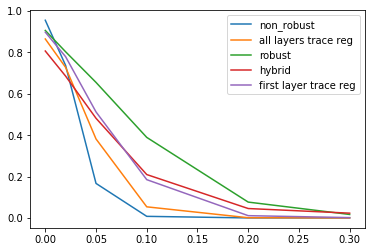

True

In [96]:
make_plot_acc_vs_eps(model_list, sess_list, eps_list, legend_list, scope_list, pgd = True)

## Black box accuracies

In [99]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
eps_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
angle_list = [10, 15, 20, 25, 30, 35, 40]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non_robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

Model was evaluated on benign data
I0920 10:39:16.225590 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:16.246429 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:16.271146 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:16.294178 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:18.565536 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:18.585566 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:18.613037 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:18.637217 4522669504 feedforward_robust.py:

I0920 10:39:55.665797 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:58.458597 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:58.481169 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:58.503111 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:58.524095 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:01.022614 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:01.045768 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:01.082298 4522669504 feedforward_robust.py:356] Model was evaluated on benign 

Model was evaluated on benign data
I0920 10:40:34.478770 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:36.852066 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:36.882833 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:36.903791 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:36.925896 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:39.287863 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:39.313663 4522669504 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:39.338321 4522669504 feedforward_robust.py:

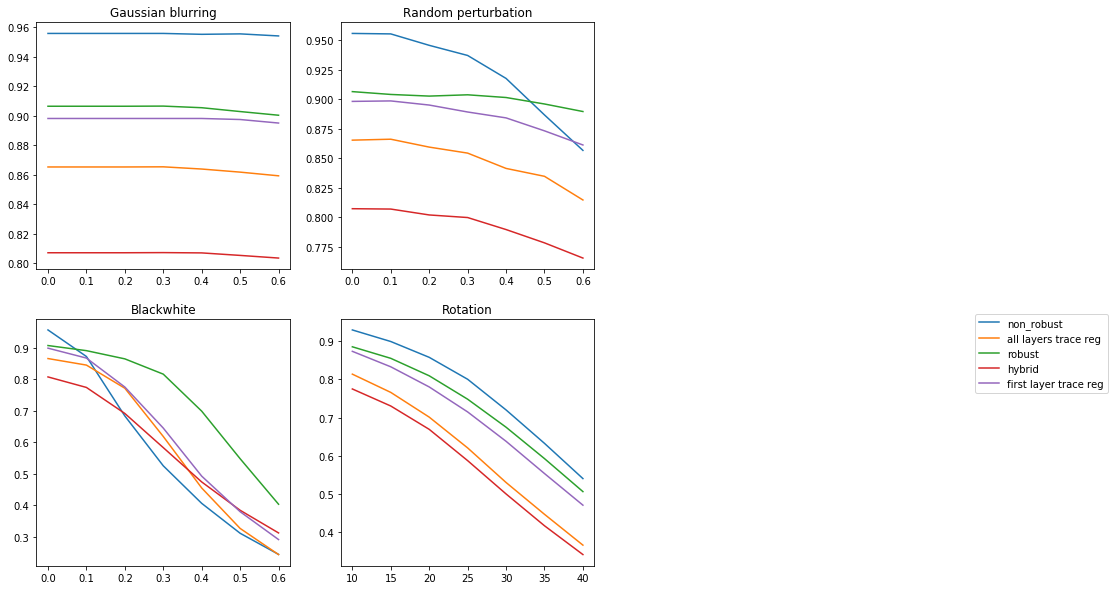

True

In [100]:
make_plot_acc_vs_eps_black_box(model_list, sess_list, eps_list, angle_list, legend_list, scope_list)

## Singular Values 

In [ ]:
norm_factor_non = sing_vals[0][0]
sing_non = sing_vals[0]/norm_factor_non
norm_factor_rob = sing_vals_robust[0][0]
sing_rob = sing_vals_robust[0]/norm_factor_rob

plt.loglog(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.loglog(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
plt.semilogy(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.semilogy(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
plt.plot(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.plot(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
def all_plots_layer_k(k):
    norm_factor_non = sing_vals[k][0]
    print("-----NORM FACTOR NON---")
    print(norm_factor_non)
    sing_non = sing_vals[k]/norm_factor_non
    norm_factor_rob = sing_vals_robust[k][0]
    print("-----NORM FACTOR ROB---")
    print(norm_factor_rob)
    sing_rob = sing_vals_robust[k]/norm_factor_rob
    plt.loglog(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.loglog(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()
    plt.semilogy(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.semilogy(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()
    plt.plot(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.plot(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()

In [ ]:
num_layers = len(sing_vals)

In [ ]:
num_layers

In [ ]:
for k in range(8):
    print(k)
    print("-----------")
    all_plots_layer_k(k)
    print("-----------")

In [ ]:
for k in range(8):
    print(k)
    print("-----------")
    all_plots_layer_k(k)
    print("-----------")